# Initialization (FastKAN)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class AttentionWithFastKANTransform(nn.Module):
    
    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.linear_q = FastKANLayer(q_dim, total_dim)
        self.linear_k = FastKANLayer(k_dim, total_dim)
        self.linear_v = FastKANLayer(v_dim, total_dim)
        self.linear_o = FastKANLayer(total_dim, q_dim)
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim)
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:         

        wq = self.linear_q(q).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o)
        return o

# Training

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_mnist():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.MNIST(
        root="./data_mnist", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.MNIST(
        root="./data_mnist", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    #model = FastKAN([28 * 28, 64, 10])
    model = FastKAN([28 * 28, 64, 10])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

model1 = train_mnist()

100%|██████████| 938/938 [00:06<00:00, 134.52it/s, accuracy=0.906, loss=0.482, lr=0.001] 


Epoch 1, Val Loss: 0.20824357513694247, Val Accuracy: 0.9354100318471338


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_cifar10():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=True, download=True, transform=transform
    )
    valset = torchvision.datasets.CIFAR10(
        root="./data_cifar10", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = DataLoader(valset, batch_size=64, shuffle=False)

    # Define model
    model = FastKAN([3072, 256, 10])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1):
        # Train
        model.train()
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 3072).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, 3072).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )
    return model

#model = train_cifar10()

# Verification With Constant Segments (Vanilla)

In [4]:
import numpy as np
import torch
from typing import List, Tuple
import matplotlib.pyplot as plt

def fit_line_through_points(x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept


def find_bspline_segments_given_max_segments(layer, input_index, output_index, max_segments, min_x, max_x):
    
    # Sample points from the spline
    n_samples = min(max_segments * 10, 50)
    
    # Create evenly spaced x points
    x_points = np.linspace(min_x, max_x, n_samples)
    
    # Get y values from the FastKAN layer
    x_tensor, y_tensor = layer.plot_curve(input_index, output_index, num_pts=n_samples)
    
    # Extract numpy arrays and filter to the desired range
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_points = x_np[mask]
    y_points = y_np[mask]
    
    n = len(x_points)
    if n < 2:
        return [], 0.0
    
    # Precompute errors for all possible segments
    errors = np.full((n, n), np.inf)
    
    for start_idx in range(n-1):
        # Limit the maximum length of segments
        max_len = min(n - start_idx, int(np.round((max_x - min_x) / ((max_x - min_x) / n))))
        
        # For each possible end point
        x_start = x_points[start_idx]
        y_start = y_points[start_idx]
        
        for end_idx in range(start_idx + 1, start_idx + max_len):
            if end_idx >= n:
                break
                
            x_end = x_points[end_idx]
            y_end = y_points[end_idx]
            
            # Skip if segment is too short
            if abs(x_end - x_start) <= 1e-10:
                continue
                
            # Calculate slope and intercept
            slope = (y_end - y_start) / (x_end - x_start)
            intercept = y_start - slope * x_start
            
            # Calculate predicted y values for points in this segment
            segment_x = x_points[start_idx:end_idx+1]
            segment_y = y_points[start_idx:end_idx+1]
            predicted_y = slope * segment_x + intercept
            
            # Calculate maximum error
            segment_error = np.max(np.abs(predicted_y - segment_y))
            errors[start_idx, end_idx] = segment_error
    
    # Dynamic programming to find optimal segmentation
    dp = np.full((max_segments, n), np.inf)
    back = np.zeros((max_segments, n), dtype=int)
    
    # Base case: one segment from start to j
    for j in range(1, n):
        dp[0, j] = errors[0, j]
    
    # Fill dp table
    for i in range(1, max_segments):
        for j in range(i+1, n):
            for k in range(i, j):
                if dp[i-1, k] == np.inf:
                    continue
                    
                if errors[k, j] == np.inf:
                    continue
                    
                curr_error = max(dp[i-1, k], errors[k, j])
                if curr_error < dp[i, j]:
                    dp[i, j] = curr_error
                    back[i, j] = k
    
    # Reconstruct the segments
    segments = []
    curr_seg = n - 1
    
    # If we couldn't find a valid segmentation, return empty
    if dp[max_segments-1, curr_seg] == np.inf:
        return [], np.inf
    
    # Reconstruct the segments
    for i in range(max_segments-1, -1, -1):
        if i > 0:
            prev_seg = back[i, curr_seg]
        else:
            prev_seg = 0
        
        x1, y1 = x_points[prev_seg], y_points[prev_seg]
        x2, y2 = x_points[curr_seg], y_points[curr_seg]
        
        slope, intercept = fit_line_through_points(x1, y1, x2, y2)
        segments.insert(0, (x1, x2, slope, intercept))
        
        curr_seg = prev_seg
        
        if curr_seg <= 0:
            break
    
    # Return segments and maximum error
    return segments, dp[max_segments-1, n-1]

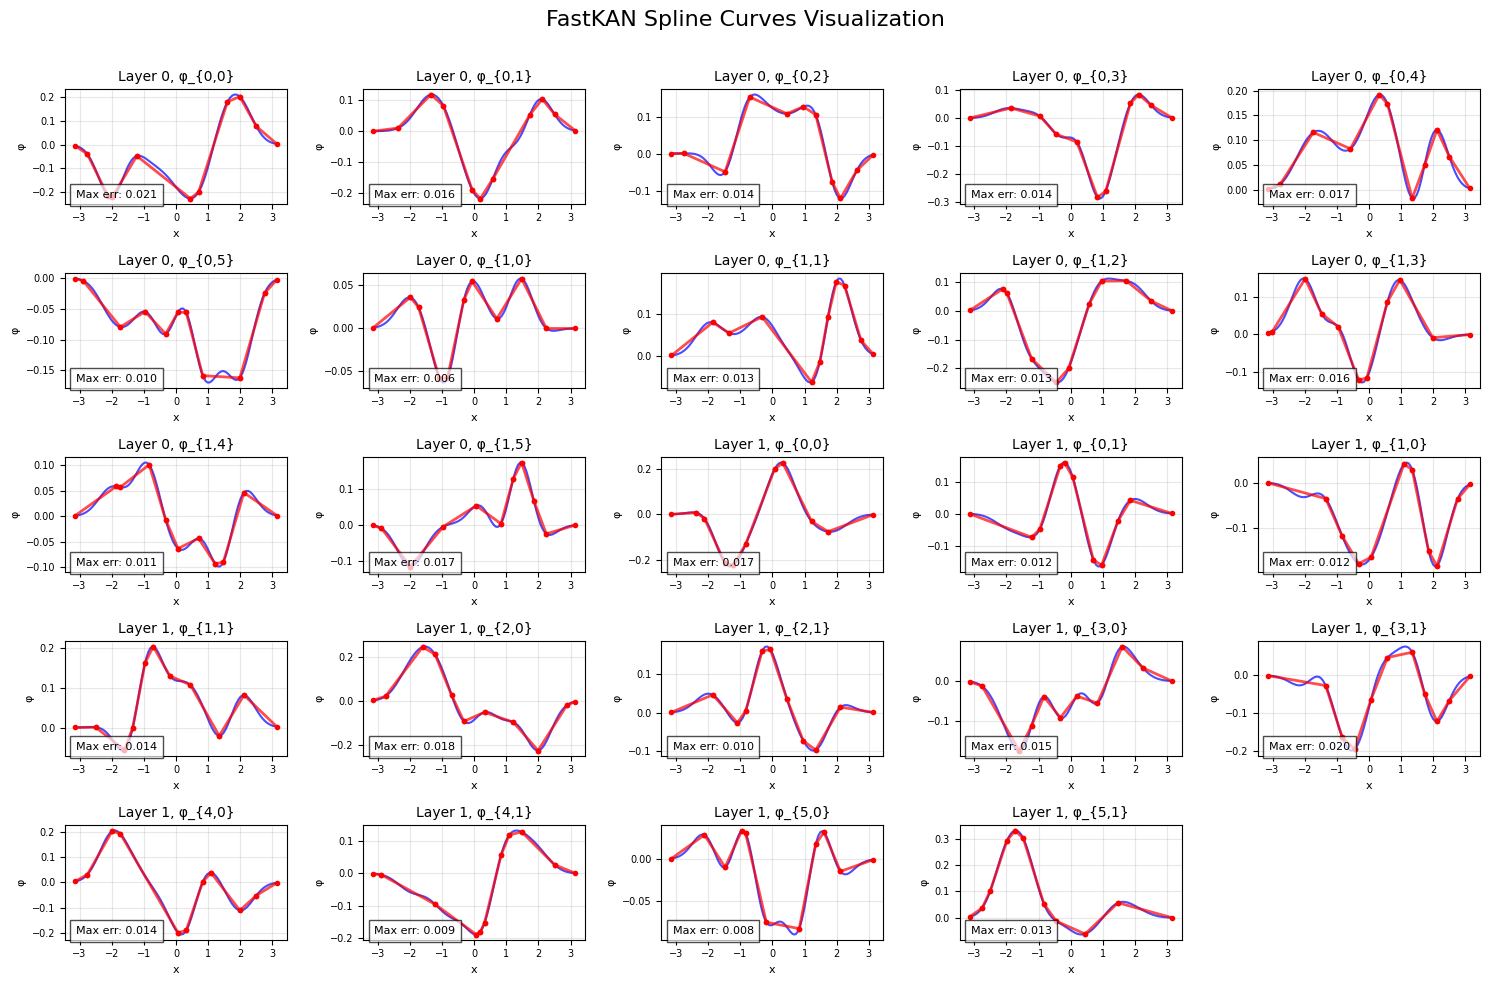

In [5]:
import matplotlib.pyplot as plt
import math
import numpy as np

def fit_kan_vanilla(kan_model, segments_per_curve, min_x=-5.0, max_x=5.0):
    all_segments = []
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        for input_index in range(input_dim):
            for output_index in range(output_dim):
                segments, max_error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, segments_per_curve, min_x, max_x
                )
                all_segments.append((
                    layer_idx, 
                    input_index, 
                    output_index, 
                    segments, 
                    max_error
                ))
    return all_segments

def plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=500,
):
    total_curves = len(all_segments)
    cols = math.ceil(math.sqrt(total_curves))
    rows = math.ceil(total_curves / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('FastKAN Spline Curves Visualization', fontsize=16)
    axes = axes.flatten()
    for idx, (layer_idx, input_index, output_index, segments, max_error) in enumerate(all_segments):
        ax = axes[idx]
        layer = kan_model.layers[layer_idx]
        x_tensor, y_tensor = layer.plot_curve(
            input_index, output_index, 
            num_pts=num_pts
        )
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        ax.plot(x_orig, y_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original')
        for x1, x2, slope, intercept in segments:
            x_seg = np.linspace(x1, x2, 50)
            y_seg = slope * x_seg + intercept
            ax.plot(x_seg, y_seg, 'r-', linewidth=2, alpha=0.7)
            ax.plot([x1], [slope * x1 + intercept], 'ro', markersize=3)
            ax.plot([x2], [slope * x2 + intercept], 'ro', markersize=3)
        ax.text(0.05, 0.05, f'Max err: {max_error:.3f}', transform=ax.transAxes, 
                fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
        ax.set_title(f'Layer {layer_idx}, φ_{{{input_index},{output_index}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    for i in range(total_curves, len(axes)):
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

kan_model = FastKAN([2, 6, 2])
all_segments = fit_kan_vanilla(
    kan_model,
    min_x=-5.0,
    max_x=5.0,
    segments_per_curve=10
)
fig = plot_kan(
    kan_model,
    all_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=100,
)
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)  # Fixed: changed segments to weight

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_segments_init_scale: float = 0.1,  # Consistent parameter name
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_segments_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve 
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[  # Fixed: changed segments to weight
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_segments_init_scale: float = 0.1,  # Consistent parameter name
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_segments_init_scale=spline_segments_init_scale,  # Fixed: consistent parameter name
                use_layernorm=(in_dim > 1),  # Fixed: explicitly set use_layernorm based on input dimension
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class AttentionWithFastKANTransform(nn.Module):
    
    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.linear_q = FastKANLayer(q_dim, total_dim, use_layernorm=(q_dim > 1))  # Fixed: explicit layernorm setting
        self.linear_k = FastKANLayer(k_dim, total_dim, use_layernorm=(k_dim > 1))  # Fixed: explicit layernorm setting
        self.linear_v = FastKANLayer(v_dim, total_dim, use_layernorm=(v_dim > 1))  # Fixed: explicit layernorm setting
        self.linear_o = FastKANLayer(total_dim, q_dim, use_layernorm=(total_dim > 1))  # Fixed: explicit layernorm setting
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim, use_layernorm=(q_dim > 1))  # Fixed: explicit layernorm setting
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:         

        wq = self.linear_q(q).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o)
        return o

import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpStatus, LpBinary, LpConstraint, lpSum, LpConstraintGE, LpConstraintLE

class DynamicSplineApproximation:
    def __init__(self, segments, max_error):
        """
        Initialize a dynamic spline approximation.
        
        Args:
            segments: List of tuples (start_x, end_x, slope, intercept)
            max_error: Maximum approximation error
        """
        self.segments = segments
        self.max_error = max_error

import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpStatus, LpBinary, LpConstraint, lpSum, LpConstraintGE, LpConstraintLE

def kan_interval_analysis_MIP(inner_approx, outer_approx, x_min, x_max):
    """
    Analyze the output range of a KAN model using Mixed Integer Programming.
    
    Parameters:
    -----------
    inner_approx : list
        List of DynamicSplineApproximation objects for the inner layer
    outer_approx : DynamicSplineApproximation
        DynamicSplineApproximation object for the outer layer
    x_min : float
        Minimum value of the input range
    x_max : float
        Maximum value of the input range
    
    Returns:
    --------
    tuple
        (min_output, max_output) - the minimum and maximum possible outputs
    """
    from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpBinary, lpSum, LpStatus
    
    def build_model(sense):
        # Create a MIP model
        model = LpProblem(name=f"KAN_{'min' if sense == LpMinimize else 'max'}_output", sense=sense)
        
        # Determine global x range
        global_x_min = min(approx.segments[0][0] for approx in inner_approx)
        global_x_max = max(approx.segments[-1][1] for approx in inner_approx)
        
        # Create variables
        x = LpVariable(name="x", lowBound=global_x_min, upBound=global_x_max)
        inner_outputs = [LpVariable(name=f"inner_output_{i}") for i in range(len(inner_approx))]
        final_y = LpVariable(name="final_y")
        
        # Add constraints for input range
        model += x >= x_min
        model += x <= x_max
        
        # Handle inner splines
        inner_indicators = []
        for i, approx in enumerate(inner_approx):
            n_segments = len(approx.segments)
            # Create binary indicators for each segment
            indicators = [LpVariable(name=f"segment_indicator_inner_{i}_{j}", cat=LpBinary) for j in range(n_segments)]
            inner_indicators.append(indicators)
            
            # Exactly one segment must be active
            model += lpSum(indicators) == 1
            
            # Add constraints for each segment
            for j, (start_x, end_x, slope, intercept) in enumerate(approx.segments):
                indicator = indicators[j]
                
                # Big-M method to enforce conditional constraints
                M = 1e9  # A large number
                
                # If indicator is 1, then x >= start_x
                model += x >= start_x - M * (1 - indicator)
                # If indicator is 1, then x <= end_x
                model += x <= end_x + M * (1 - indicator)
                
                # Calculate y based on the line equation y = slope * x + intercept
                y_approx = slope * x + intercept
                
                # If indicator is 1, enforce output bounds with error
                model += inner_outputs[i] <= y_approx + approx.max_error + M * (1 - indicator)
                model += inner_outputs[i] >= y_approx - approx.max_error - M * (1 - indicator)
        
        # Handle outer spline
        inner_sum = lpSum(inner_outputs)
        
        # Determine outer range
        outer_min = min(segment[0] for segment in outer_approx.segments)
        outer_max = max(segment[1] for segment in outer_approx.segments)
        
        # Ensure inner sum is within outer range
        model += inner_sum >= outer_min
        model += inner_sum <= outer_max
        
        # Create indicators for outer segments
        n_outer_segments = len(outer_approx.segments)
        outer_indicators = [LpVariable(name=f"segment_indicator_outer_{j}", cat=LpBinary) for j in range(n_outer_segments)]
        
        # Exactly one segment must be active
        model += lpSum(outer_indicators) == 1
        
        # Add constraints for each outer segment
        for j, (start_x, end_x, slope, intercept) in enumerate(outer_approx.segments):
            indicator = outer_indicators[j]
            
            # Big-M method for conditional constraints
            M = 1e6
            
            # If indicator is 1, then inner_sum >= start_x
            model += inner_sum >= start_x - M * (1 - indicator)
            # If indicator is 1, then inner_sum <= end_x
            model += inner_sum <= end_x + M * (1 - indicator)
            
            # Calculate final y based on the line equation
            y_approx = slope * inner_sum + intercept
            
            # If indicator is 1, enforce output bounds with error
            model += final_y <= y_approx + outer_approx.max_error + M * (1 - indicator)
            model += final_y >= y_approx - outer_approx.max_error - M * (1 - indicator)
        
        # Set objective
        model += final_y
        
        return model, final_y
    
    # Find minimum output
    model_min, final_y_min = build_model(LpMinimize)
    model_min.solve()
    
    min_output = final_y_min.value()
    
    # Find maximum output
    model_max, final_y_max = build_model(LpMaximize)
    model_max.solve()
    
    max_output = final_y_max.value()
    
    return (min_output, max_output)

def fit_kan_to_spline_approximation(kan_segments, num_inputs=3, num_outputs=1):
    """
    Convert the segments from fit_kan_vanilla() to DynamicSplineApproximation objects.
    
    Args:
        kan_segments: Output from fit_kan_vanilla() - list of tuples (layer_idx, input_idx, output_idx, segments, max_error)
        num_inputs: Number of input nodes
        num_outputs: Number of output nodes
        
    Returns:
        tuple: (inner_approx, outer_approx) with the spline approximations
    """
    # Group segments by layer
    layer_0_segments = [seg for seg in kan_segments if seg[0] == 0]
    layer_1_segments = [seg for seg in kan_segments if seg[0] == 1]
    
    # Create inner approximations (for layer 0)
    inner_approx = []
    for input_idx in range(num_inputs):
        segments_for_node = [seg for seg in layer_0_segments if seg[1] == input_idx]
        if not segments_for_node:
            # Create an empty approximation if no segments found
            inner_approx.append(DynamicSplineApproximation([], 0.0))
            continue
        
        # Use the first output connection (assuming there's at least one)
        seg_data = segments_for_node[0]
        segments = seg_data[3]  # Access by index instead of using .get()
        max_error = seg_data[4]  # Access by index
        
        inner_approx.append(DynamicSplineApproximation(segments, max_error))
    
    # Create outer approximation (for layer 1)
    # For each output node
    outer_segments = []
    max_error = 0
    
    for output_idx in range(num_outputs):
        segs_for_output = [seg for seg in layer_1_segments if seg[2] == output_idx]
        
        for seg_data in segs_for_output:
            segments = seg_data[3]  # Access by index
            error = seg_data[4]     # Access by index
            outer_segments.extend(segments)
            max_error = max(max_error, error)
    
    # Sort segments by start_x
    outer_segments.sort(key=lambda x: x[0])
    
    # Create empty approximation if no segments
    if not outer_segments:
        outer_approx = DynamicSplineApproximation([], 0.0)
    else:
        # Merge overlapping segments (simple approach)
        merged_segments = []
        current = outer_segments[0]
        for segment in outer_segments[1:]:
            if segment[0] <= current[1]:  # Segments overlap
                # Extend current segment
                current = (current[0], max(current[1], segment[1]), current[2], current[3])
            else:
                merged_segments.append(current)
                current = segment
        merged_segments.append(current)
        
        outer_approx = DynamicSplineApproximation(merged_segments, max_error)
    
    return inner_approx, outer_approx

# Example usage:
# from the fit_kan_vanilla function in your provided code
kan_model = FastKAN([3, 1, 1])
kan_segments = fit_kan_vanilla(kan_model, segments_per_curve=10, min_x=-5.0, max_x=5.0)
inner_approx, outer_approx = fit_kan_to_spline_approximation(kan_segments)
output_range = kan_interval_analysis_MIP(inner_approx, outer_approx, x_min=-2.0, x_max=2.0)
print(f"Output range: {output_range}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/noahschwartz/Desktop/Verifying_NNs/KAN/.venv/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/d_/pj_vvqcj1lj9fqtdrzb8hgjm0000gn/T/82a40421d32e4559b7228db017f8e4b1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/d_/pj_vvqcj1lj9fqtdrzb8hgjm0000gn/T/82a40421d32e4559b7228db017f8e4b1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 137 COLUMNS
At line 558 RHS
At line 691 BOUNDS
At line 729 ENDATA
Problem MODEL has 132 rows, 36 columns and 357 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -0.0130612 - 0.00 seconds
Cgl0003I 7 fixed, 0 tightened bounds, 58 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 51 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 39 strengthened rows, 0 su

In [ ]:
import numpy as np
import math
import time
from typing import List, Tuple, Callable
import pulp

# --- Necessary Code from the Prompt ---

# Need DynamicSplineApproximation class
class DynamicSplineApproximation:
    def __init__(self, segments: List[Tuple[float, float, float, float]], max_error: float):
        """
        Initialize a dynamic spline approximation.
        Args:
            segments: List of tuples (start_x, end_x, slope, intercept), sorted by start_x.
            max_error: Maximum approximation error associated with these segments relative to the original function.
        """
        # Ensure segments are sorted by start_x for efficient lookup
        self.segments = sorted(segments, key=lambda s: s[0])
        self.max_error = max_error
        # Precompute bounds for faster checks
        self.min_x = segments[0][0] if segments else -np.inf
        self.max_x = segments[-1][1] if segments else np.inf

# Need kan_interval_analysis_MIP function
def kan_interval_analysis_MIP(inner_approx: List[DynamicSplineApproximation],
                              outer_approx: DynamicSplineApproximation,
                              x_min: float, x_max: float):
    """
    Analyze the output range of a KAN model (specific structure assumed) using Mixed Integer Programming.

    Parameters:
    -----------
    inner_approx : list
        List of DynamicSplineApproximation objects for the inner layer (each mapping x -> hidden_i).
    outer_approx : DynamicSplineApproximation
        DynamicSplineApproximation object for the outer layer (mapping sum(hidden_i) -> y).
    x_min : float
        Minimum value of the input range for x.
    x_max : float
        Maximum value of the input range for x.

    Returns:
    --------
    tuple
        (min_output, max_output) - the minimum and maximum possible outputs, considering approximation errors.
        Returns (None, None) if the model is infeasible or solver fails.
    """
    from pulp import LpProblem, LpVariable, LpMinimize, LpMaximize, LpBinary, lpSum, LpStatus, PULP_CBC_CMD

    num_inner = len(inner_approx)
    if num_inner == 0 or not outer_approx.segments:
         print("Warning: No inner or outer approximations provided.")
         # Cannot determine bounds without approximations
         # Or, if num_inner is 0, the sum is 0, need to evaluate outer_approx at 0.
         if num_inner == 0:
             # Evaluate outer spline at 0
             val_at_0, _ = evaluate_spline(0.0, outer_approx)
             if val_at_0 is None: return None, None # 0 is outside outer spline domain
             return val_at_0 - outer_approx.max_error, val_at_0 + outer_approx.max_error
         return None, None # Outer approx has no segments


    def build_model(sense):
        model = LpProblem(name=f"KAN_{'min' if sense == LpMinimize else 'max'}_output", sense=sense)

        # --- Determine global bounds for variables from segments ---
        # For x
        all_inner_min_x = min(app.min_x for app in inner_approx if app.segments)
        all_inner_max_x = max(app.max_x for app in inner_approx if app.segments)
        # Ensure variable bounds encompass the test range [x_min, x_max]
        # and the segment definitions. Use slightly wider bounds for safety.
        global_x_min_bound = min(x_min, all_inner_min_x) - 1e-6
        global_x_max_bound = max(x_max, all_inner_max_x) + 1e-6

        # For inner_sum
        # Estimate bounds for inner_outputs based on segments (can be loose)
        min_possible_inner_sum = 0
        max_possible_inner_sum = 0
        for approx in inner_approx:
            if not approx.segments: continue
            min_y = min(min(s[2]*s[0]+s[3], s[2]*s[1]+s[3]) for s in approx.segments) - approx.max_error
            max_y = max(max(s[2]*s[0]+s[3], s[2]*s[1]+s[3]) for s in approx.segments) + approx.max_error
            min_possible_inner_sum += min_y
            max_possible_inner_sum += max_y

        outer_min_x_bound = outer_approx.min_x
        outer_max_x_bound = outer_approx.max_x

        # Ensure inner_sum bounds encompass the outer spline domain
        global_sum_min_bound = min(min_possible_inner_sum, outer_min_x_bound) - 1e-6
        global_sum_max_bound = max(max_possible_inner_sum, outer_max_x_bound) + 1e-6

        # --- Create Variables ---
        x = LpVariable(name="x", lowBound=global_x_min_bound, upBound=global_x_max_bound)
        inner_outputs = [LpVariable(name=f"inner_output_{i}", lowBound=None, upBound=None) for i in range(num_inner)] # Bounds enforced by segments
        inner_sum = LpVariable(name="inner_sum", lowBound=global_sum_min_bound, upBound=global_sum_max_bound)
        final_y = LpVariable(name="final_y", lowBound=None, upBound=None)

        # Big-M values (choose carefully, should be larger than max possible deviation)
        M_range = 1e6 # Should be larger than typical ranges of variables
        M_error = 1e6 # Should be larger than typical y ranges + errors

        # --- Constraints ---
        # Input range constraint
        model += x >= x_min, "Input_Lower_Bound"
        model += x <= x_max, "Input_Upper_Bound"

        # Inner Spline Constraints
        for i, approx in enumerate(inner_approx):
            if not approx.segments:
                 model += inner_outputs[i] == 0.0 # Handle empty approximation
                 continue
            n_segments = len(approx.segments)
            indicators = [LpVariable(name=f"z_inner_{i}_{j}", cat=LpBinary) for j in range(n_segments)]

            model += lpSum(indicators) == 1, f"Inner_{i}_Choose_Segment"

            # Link x to active segment and constrain inner_outputs[i]
            for j, (start_x, end_x, slope, intercept) in enumerate(approx.segments):
                indicator = indicators[j]
                y_approx = slope * x + intercept

                # If indicator is 1, x must be in [start_x, end_x]
                # x >= start_x - M * (1 - indicator)
                model += x >= start_x - M_range * (1 - indicator), f"Inner_{i}_{j}_X_Lower"
                # x <= end_x + M * (1 - indicator)
                model += x <= end_x + M_range * (1 - indicator), f"Inner_{i}_{j}_X_Upper"

                # If indicator is 1, inner_outputs[i] must be within error bounds of y_approx
                # inner_outputs[i] <= y_approx + max_error + M * (1 - indicator)
                model += inner_outputs[i] <= y_approx + approx.max_error + M_error * (1 - indicator), f"Inner_{i}_{j}_Y_Upper"
                # inner_outputs[i] >= y_approx - max_error - M * (1 - indicator)
                model += inner_outputs[i] >= y_approx - approx.max_error - M_error * (1 - indicator), f"Inner_{i}_{j}_Y_Lower"

        # Link inner_outputs to inner_sum
        model += inner_sum == lpSum(inner_outputs), "Sum_Calculation"

        # Outer Spline Constraints
        n_outer_segments = len(outer_approx.segments)
        outer_indicators = [LpVariable(name=f"z_outer_{j}", cat=LpBinary) for j in range(n_outer_segments)]

        model += lpSum(outer_indicators) == 1, "Outer_Choose_Segment"

        # Ensure inner_sum is within the domain defined by the outer segments (redundant if bounds are tight, but safer)
        # model += inner_sum >= outer_approx.min_x, "Outer_Domain_Min"
        # model += inner_sum <= outer_approx.max_x, "Outer_Domain_Max"


        # Link inner_sum to active outer segment and constrain final_y
        for j, (start_s, end_s, slope, intercept) in enumerate(outer_approx.segments):
            indicator = outer_indicators[j]
            y_approx = slope * inner_sum + intercept

            # If indicator is 1, inner_sum must be in [start_s, end_s]
            model += inner_sum >= start_s - M_range * (1 - indicator), f"Outer_{j}_S_Lower"
            model += inner_sum <= end_s + M_range * (1 - indicator), f"Outer_{j}_S_Upper"

            # If indicator is 1, final_y must be within error bounds of y_approx
            model += final_y <= y_approx + outer_approx.max_error + M_error * (1 - indicator), f"Outer_{j}_Y_Upper"
            model += final_y >= y_approx - outer_approx.max_error - M_error * (1 - indicator), f"Outer_{j}_Y_Lower"

        # Set Objective
        model += final_y

        return model, final_y

    # --- Solve for Min ---
    min_output = None
    model_min, final_y_min = build_model(LpMinimize)
    # Use CBC solver, handle potential errors
    solver = PULP_CBC_CMD(msg=False)
    model_min.solve(solver)
    if LpStatus[model_min.status] == 'Optimal':
        min_output = final_y_min.value()
    elif LpStatus[model_min.status] == 'Infeasible':
        print("Warning: Minimization problem is infeasible.")
    else:
        print(f"Warning: Minimization solve failed. Status: {LpStatus[model_min.status]}")

    # --- Solve for Max ---
    max_output = None
    model_max, final_y_max = build_model(LpMaximize)
    model_max.solve(solver)
    if LpStatus[model_max.status] == 'Optimal':
        max_output = final_y_max.value()
    elif LpStatus[model_max.status] == 'Infeasible':
        print("Warning: Maximization problem is infeasible.")
    else:
        print(f"Warning: Maximization solve failed. Status: {LpStatus[model_max.status]}")

    return (min_output, max_output)

# --- Helper Functions for Testing ---

def fit_line_through_points(x1, y1, x2, y2):
    if abs(x2 - x1) < 1e-12:
        slope = 0.0
        intercept = y1
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
    return slope, intercept

def approximate_function_with_splines(
    func: Callable[[float], float],
    num_segments: int,
    x_range_min: float,
    x_range_max: float,
    n_samples: int = 200
) -> DynamicSplineApproximation:
    """
    Approximates a given Python function with a piecewise linear spline
    using a specified number of segments. Adapts logic from
    find_bspline_segments_given_max_segments but operates on a Callable.
    """
    if num_segments <= 0:
        return DynamicSplineApproximation([], 0.0)

    # 1. Sample the function
    x_points = np.linspace(x_range_min, x_range_max, n_samples)
    y_points = np.array([func(x) for x in x_points])
    n = len(x_points)

    if n < 2:
        return DynamicSplineApproximation([], 0.0)

    # 2. Precompute errors (O(n^3))
    errors = np.full((n, n), np.inf, dtype=np.float64)
    for start_idx in range(n - 1):
        x_start, y_start = x_points[start_idx], y_points[start_idx]
        for end_idx in range(start_idx + 1, n):
            x_end, y_end = x_points[end_idx], y_points[end_idx]
            if abs(x_end - x_start) < 1e-12:
                segment_error = np.max(np.abs(y_points[start_idx:end_idx+1] - y_start)) if start_idx < end_idx else 0.0
            else:
                slope = (y_end - y_start) / (x_end - x_start)
                intercept = y_start - slope * x_start
                segment_x = x_points[start_idx : end_idx + 1]
                segment_y = y_points[start_idx : end_idx + 1]
                predicted_y = slope * segment_x + intercept
                segment_error = np.max(np.abs(predicted_y - segment_y))
            errors[start_idx, end_idx] = segment_error

    # 3. Dynamic Programming (O(num_segments * n^2))
    dp = np.full((num_segments, n), np.inf, dtype=np.float64)
    back = np.zeros((num_segments, n), dtype=int)
    for j in range(1, n):
        dp[0, j] = errors[0, j]

    for k in range(1, num_segments):
        for j in range(k + 1, n):
            min_err_for_j = np.inf
            best_split_idx = -1
            for i in range(k, j):
                current_max_error = max(dp[k - 1, i], errors[i, j])
                if current_max_error < min_err_for_j:
                    min_err_for_j = current_max_error
                    best_split_idx = i
            if best_split_idx != -1:
                dp[k, j] = min_err_for_j
                back[k, j] = best_split_idx

    # 4. Reconstruct and find actual max error
    segments_out = []
    final_max_error = dp[num_segments - 1, n - 1]

    # Find best result potentially using fewer segments
    actual_segments_used = 0
    min_final_error = np.inf
    best_k = -1
    for k in range(num_segments):
        if dp[k, n-1] < min_final_error:
            min_final_error = dp[k, n-1]
            actual_segments_used = k + 1
            best_k = k

    if min_final_error == np.inf:
        return DynamicSplineApproximation([], np.inf) # No solution

    final_max_error = min_final_error
    num_segs_to_reconstruct = actual_segments_used
    current_end_idx = n - 1

    for k_idx in range(num_segs_to_reconstruct - 1, -1, -1):
        start_idx = back[k_idx, current_end_idx] if k_idx > 0 else 0
        x1, y1 = x_points[start_idx], y_points[start_idx]
        x2, y2 = x_points[current_end_idx], y_points[current_end_idx]
        slope, intercept = fit_line_through_points(x1, y1, x2, y2)
        segments_out.insert(0, (x1, x2, slope, intercept))
        current_end_idx = start_idx
        if current_end_idx <= 0 and k_idx > 0: break

    # The error returned by DP is the max error achieved by the segments
    return DynamicSplineApproximation(segments_out, final_max_error)


def evaluate_spline(value: float, approx: DynamicSplineApproximation) -> Tuple[float | None, bool]:
    """Evaluates the piecewise linear function defined by the approximation at a given value."""
    if not approx.segments:
        return 0.0, True # Treat empty spline as constant 0

    # Find the segment containing the value
    active_segment = None
    for start_x, end_x, slope, intercept in approx.segments:
        # Use a small tolerance for floating point comparisons at boundaries
        if start_x - 1e-9 <= value <= end_x + 1e-9:
            active_segment = (slope, intercept)
            break # Assuming segments are sorted and non-overlapping except at endpoints

    if active_segment:
        slope, intercept = active_segment
        return slope * value + intercept, True
    else:
        # Value is outside the domain defined by the segments
        # Handle extrapolation carefully or return None
        # For testing, let's return None if outside range
        # Check if value is near boundaries due to tolerance
        if value < approx.min_x - 1e-9 or value > approx.max_x + 1e-9:
           return None, False # Outside defined range
        else: # Should have been caught by segment check if within boundaries
            print(f"Warning: Value {value} within spline bounds [{approx.min_x}, {approx.max_x}] but no segment found.")
            # Fallback: Find closest segment end? Or just fail? Let's fail.
            return None, False


def sample_approximated_kan(inner_approx: List[DynamicSplineApproximation],
                            outer_approx: DynamicSplineApproximation,
                            x_min: float, x_max: float,
                            n_samples: int = 10000) -> Tuple[float | None, float | None]:
    """
    Samples the KAN structure defined by the spline approximations
    (matching the MILP structure) to estimate the output range.
    """
    min_y_sampled = np.inf
    max_y_sampled = -np.inf
    sampled_count = 0

    x_values = np.linspace(x_min, x_max, n_samples)

    for x_val in x_values:
        # 1. Calculate inner outputs
        current_inner_outputs = []
        valid_inner = True
        for approx in inner_approx:
            inner_y, success = evaluate_spline(x_val, approx)
            if not success:
                valid_inner = False
                break
            current_inner_outputs.append(inner_y)

        if not valid_inner:
            continue # Skip x_val if any inner spline is undefined

        # 2. Calculate inner sum
        current_inner_sum = sum(current_inner_outputs)

        # 3. Calculate final output
        final_y, success = evaluate_spline(current_inner_sum, outer_approx)

        if success:
            sampled_count += 1
            min_y_sampled = min(min_y_sampled, final_y)
            max_y_sampled = max(max_y_sampled, final_y)

    if sampled_count == 0:
        return None, None # No valid outputs found in the sampling range
    return min_y_sampled, max_y_sampled

# --- Test Function ---

def test_kan_interval_analysis(tolerance=1e-4):
    """
    Tests the kan_interval_analysis_MIP function against sampling.
    """
    test_scenarios = [
        # Config: (num_inner_splines, segments_per_spline, x_range, inner_funcs, outer_func)
        (1, 5, (-2, 2), [lambda x: x**2], lambda s: np.sin(s)),
        (1, 8, (-1, 1), [lambda x: np.sin(np.pi * x)], lambda s: s * 2),
        (2, 5, (-3, 3), [lambda x: x, lambda x: -0.5*x], lambda s: np.tanh(s)),
        (3, 6, (-1, 1), [lambda x: x**3, lambda x: np.cos(x*2), lambda x: 0.5], lambda s: s**2 / (abs(s)+1)),
        (3, 10, (-2, 2), [lambda x: np.exp(-x*x), lambda x: x/2, lambda x: np.sin(x)], lambda s: np.log(abs(s)+1) * np.sign(s) if s != 0 else 0),
        (1, 4, (0, 5), [lambda x: np.sqrt(x)], lambda s: -s), # Test non-centered range
        (2, 7, (-4, 0), [lambda x: x+2, lambda x: (x/2)**2], lambda s: np.exp(s/5)), # Test negative range
        # Scenario with potentially tight bounds or infeasibility if ranges mismatch badly
        (1, 5, (-1, 1), [lambda x: x * 10], lambda s: s / 10 if -1 <= s <= 1 else np.nan), # Outer func only defined in small range
    ]

    print("Starting KAN Interval Analysis MILP Tests...")
    print("-" * 60)

    passed_count = 0
    failed_count = 0

    for i, (num_inner, segs_per, x_range, inner_f, outer_f) in enumerate(test_scenarios):
        print(f"Test Case {i+1}: Inner={num_inner}, Segments={segs_per}, Range={x_range}")
        x_min, x_max = x_range

        # --- Generate Spline Approximations ---
        start_time_approx = time.time()
        inner_approximations = []
        valid_approx = True
        for func in inner_f:
            approx = approximate_function_with_splines(func, segs_per, x_min, x_max)
            if not approx.segments:
                 print(f"  Warning: Failed to create inner approximation for {func.__name__}. Max Error: {approx.max_error}")
                 # valid_approx = False; break # Option: Skip test if approx fails
                 # Let's allow empty approx for now, MILP/sampling should handle it
            inner_approximations.append(approx)
        # if not valid_approx: continue

        # Determine range for outer function based on estimated inner sum range
        # (Could refine this range estimate, but sampling covers it)
        approx_outer_min = -5.0 # Heuristic range for outer spline approximation
        approx_outer_max = 5.0  # Might need adjustment based on inner functions

        outer_approximation = approximate_function_with_splines(outer_f, segs_per, approx_outer_min, approx_outer_max)
        if not outer_approximation.segments:
             print(f"  Warning: Failed to create outer approximation. Max Error: {outer_approximation.max_error}")
             # Skip test if outer approx fails critically
             # continue

        approx_time = time.time() - start_time_approx
        print(f"  Approximation generated in {approx_time:.2f}s")
        # print(f"    Inner Max Errors: {[a.max_error for a in inner_approximations]}")
        # print(f"    Outer Max Error: {outer_approximation.max_error}")


        # --- Run MILP ---
        start_time_milp = time.time()
        min_milp, max_milp = kan_interval_analysis_MIP(inner_approximations, outer_approximation, x_min, x_max)
        milp_time = time.time() - start_time_milp
        print(f"  MILP Result: [{min_milp}, {max_milp}] (solved in {milp_time:.2f}s)")

        # --- Run Sampling ---
        start_time_sample = time.time()
        min_sampled, max_sampled = sample_approximated_kan(inner_approximations, outer_approximation, x_min, x_max)
        sample_time = time.time() - start_time_sample
        print(f"  Sampling Result: [{min_sampled}, {max_sampled}] (sampled in {sample_time:.2f}s)")

        # --- Compare ---
        # Handle cases where MILP or sampling failed
        if min_milp is None or max_milp is None:
            print("  Status: FAIL (MILP failed to find optimal solution)")
            failed_count += 1
        elif min_sampled is None or max_sampled is None:
            # If MILP found a bound but sampling found nothing, it might be ok if the feasible region is tiny/empty
            # Or if the sampling couldn't evaluate due to domain mismatches defined by segments
            print("  Status: INCONCLUSIVE (Sampling found no valid points in range)")
            # Consider this a pass if MILP also indicated infeasibility, otherwise maybe fail?
            # For now, don't count as pass or fail.
            if LpStatus[model_min.status] != 'Infeasible' and LpStatus[model_max.status] != 'Infeasible':
                 print("    (MILP was feasible, discrepancy needs investigation)")
                 # failed_count += 1 # Treat as failure if MILP was feasible
        else:
            # Check if MILP bounds enclose the sampled bounds (within tolerance)
            # MILP bounds already include the approximation error margins.
            # Sampling evaluates the spline without the error margin.
            # So, MILP bounds should strictly enclose sampled bounds.
            lower_bound_ok = min_milp <= min_sampled + tolerance
            upper_bound_ok = max_milp >= max_sampled - tolerance

            if lower_bound_ok and upper_bound_ok:
                print("  Status: PASS")
                passed_count += 1
            else:
                print("  Status: FAIL")
                if not lower_bound_ok:
                    print(f"    Reason: MILP min ({min_milp:.6f}) > Sampled min ({min_sampled:.6f}) + tolerance")
                if not upper_bound_ok:
                    print(f"    Reason: MILP max ({max_milp:.6f}) < Sampled max ({max_sampled:.6f}) - tolerance")
                failed_count += 1

        print("-" * 60)

    print(f"Test Summary: {passed_count} passed, {failed_count} failed.")
    return failed_count == 0

# --- Run the tests ---
if __name__ == "__main__":
    test_kan_interval_analysis()

Starting KAN Interval Analysis MILP Tests...
------------------------------------------------------------
Test Case 1: Inner=1, Segments=5, Range=(-2, 2)
  Approximation generated in 0.15s
  MILP Result: [-0.89561561, 1.2147668] (solved in 0.08s)
  Sampling Result: [-0.575442899682566, 0.9995503744802221] (sampled in 0.01s)
  Status: PASS
------------------------------------------------------------
Test Case 2: Inner=1, Segments=8, Range=(-1, 1)
  Approximation generated in 0.17s
  MILP Result: [-2.0752547, 2.1026055] (solved in 0.08s)
  Sampling Result: [-1.972537714221536, 1.9998210122905895] (sampled in 0.01s)
  Status: PASS
------------------------------------------------------------
Test Case 3: Inner=2, Segments=5, Range=(-3, 3)
  Approximation generated in 0.23s
  MILP Result: [-0.93745629, 0.93745629] (solved in 0.06s)
  Sampling Result: [-0.8915231069510459, 0.8915231069510458] (sampled in 0.01s)
  Status: PASS
------------------------------------------------------------
Test 

# Verification With Lipschitz

![image.png](python_lipschitz.png)

Analyzing B-spline at Layer 0, Input 0, Output 2...
Computing error table up to 10 segments

Error table (segments -> error):
  1 segments: 0.2274
  2 segments: 0.0842
  3 segments: 0.0587
  4 segments: 0.0481
  5 segments: 0.0304
  6 segments: 0.0254
  7 segments: 0.0223
  8 segments: 0.0178
  9 segments: 0.0127
  10 segments: 0.0117


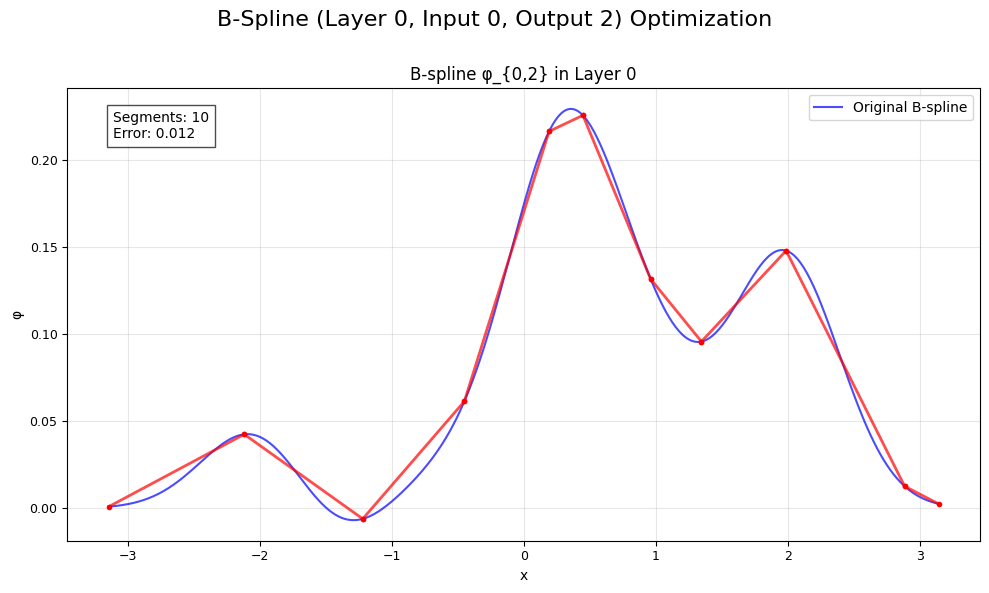

In [ ]:
def visualize_optimized_bspline(kan_model, layer_idx, input_idx, output_idx, num_segments, 
                               segments_table, error_table, min_x=-5.0, max_x=5.0, figsize=(10, 6)):
    """
    Visualize the optimized B-spline approximation for a specific B-spline.
    
    Parameters:
    - kan_model: The FastKAN model
    - layer_idx: The index of the layer containing the B-spline
    - input_idx: The input index of the B-spline
    - output_idx: The output index of the B-spline
    - num_segments: Number of segments to display
    - segments_table: Dictionary mapping num_segments to the segment definitions
    - error_table: Dictionary mapping num_segments to error
    - min_x, max_x: Range of x values to consider
    - figsize: Size of the figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(f'B-Spline (Layer {layer_idx}, Input {input_idx}, Output {output_idx}) Optimization', fontsize=16)
    
    # Get the original B-spline curve
    layer = kan_model.layers[layer_idx]
    x_tensor, y_tensor = layer.plot_curve(
        input_idx, output_idx, 
        num_pts=500
    )
    
    x_orig = x_tensor.detach().cpu().numpy()
    y_orig = y_tensor.detach().cpu().numpy()
    
    # Filter to desired range
    mask = (x_orig >= min_x) & (x_orig <= max_x)
    x_orig = x_orig[mask]
    y_orig = y_orig[mask]
    
    # Plot original curve
    ax.plot(x_orig, y_orig, 'b-', linewidth=1.5, alpha=0.7, label='Original B-spline')
    
    # Get the segments and error from the tables
    segments = segments_table[num_segments]
    error = error_table[num_segments]
    
    # Plot optimized segments
    for x1, x2, slope, intercept in segments:
        x_seg = np.linspace(x1, x2, 50)
        y_seg = slope * x_seg + intercept
        ax.plot(x_seg, y_seg, 'r-', linewidth=2, alpha=0.7)
        ax.plot([x1], [slope * x1 + intercept], 'ro', markersize=3)
        ax.plot([x2], [slope * x2 + intercept], 'ro', markersize=3)
    
    ax.text(0.05, 0.95, f'Segments: {num_segments}\nError: {error:.3f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f'B-spline φ_{{{input_idx},{output_idx}}} in Layer {layer_idx}', fontsize=12)
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel(f'φ', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

def optimize_bspline(kan_model, layer_idx, input_idx, output_idx, 
                    min_x=-5.0, max_x=5.0, max_segments=15):
    """
    Analyze a single B-spline by computing the error for different numbers of linear segments
    up to a specified maximum.
    
    Parameters:
    - kan_model: The FastKAN model
    - layer_idx: The index of the layer containing the B-spline
    - input_idx: The input index of the B-spline
    - output_idx: The output index of the B-spline
    - min_x, max_x: Range of x values to consider
    - max_segments: Maximum number of segments to evaluate
    
    Returns:
    - error_table: Dictionary mapping num_segments to error
    - segments_table: Dictionary mapping num_segments to the segment definitions
    """
    layer = kan_model.layers[layer_idx]
    
    # Generate the error table for this B-spline
    error_table = {}
    segments_table = {}
    
    for num_segments in range(1, max_segments + 1):
        segments, error = find_bspline_segments_given_max_segments(
            layer, input_idx, output_idx, num_segments, min_x, max_x
        )
        error_table[num_segments] = error
        segments_table[num_segments] = segments
    
    return error_table, segments_table

def run_bspline_optimization_example():
    # Create a FastKAN model
    kan_model = FastKAN([2, 6, 2])
    
    # Define the range of x values to consider
    min_x = -5.0
    max_x = 5.0
    
    # Select a B-spline to optimize
    layer_idx = 0
    input_idx = 0
    output_idx = 2
    
    # Set the maximum number of segments to evaluate
    max_segments = 10
    
    print(f"Analyzing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
    print(f"Computing error table up to {max_segments} segments")
    
    # Run the analysis
    error_table, segments_table = optimize_bspline(
        kan_model=kan_model,
        layer_idx=layer_idx,
        input_idx=input_idx,
        output_idx=output_idx,
        min_x=min_x,
        max_x=max_x,
        max_segments=max_segments
    )
    
    # Print the error table
    print("\nError table (segments -> error):")
    for n_seg in sorted(error_table.keys()):
        print(f"  {n_seg} segments: {error_table[n_seg]:.4f}")
    
    # Select a specific number of segments to visualize
    viz_segments = max_segments  # Or choose any value between 1 and max_segments
    
    # Visualize the results
    fig = visualize_optimized_bspline(
        kan_model=kan_model,
        layer_idx=layer_idx,
        input_idx=input_idx,
        output_idx=output_idx,
        num_segments=viz_segments,
        segments_table=segments_table,
        error_table=error_table,
        min_x=min_x,
        max_x=max_x
    )
    
    plt.show()
    
    return error_table, segments_table

# Execute the example if run directly
if __name__ == "__main__":
    error_table, segments_table = run_bspline_optimization_example()

Creating example FastKAN model...

Comparing original and weighted error tables...
Analyzing Layer 0: 2 inputs -> 3 outputs
  Processing B-spline at Layer 0, Input 0, Output 0...
    Lipschitz constant: 0.2402261197566986
  Processing B-spline at Layer 0, Input 0, Output 1...
    Lipschitz constant: 0.3403165936470032
  Processing B-spline at Layer 0, Input 0, Output 2...
    Lipschitz constant: 0.34216147661209106
  Processing B-spline at Layer 0, Input 1, Output 0...
    Lipschitz constant: 0.39396989345550537
  Processing B-spline at Layer 0, Input 1, Output 1...
    Lipschitz constant: 0.531146228313446
  Processing B-spline at Layer 0, Input 1, Output 2...
    Lipschitz constant: 0.29496920108795166
Analyzing Layer 1: 3 inputs -> 2 outputs
  Processing B-spline at Layer 1, Input 0, Output 0...
    Lipschitz constant: 0.5523104667663574
  Processing B-spline at Layer 1, Input 0, Output 1...
    Lipschitz constant: 0.49418362975120544
  Processing B-spline at Layer 1, Input 1, Outpu

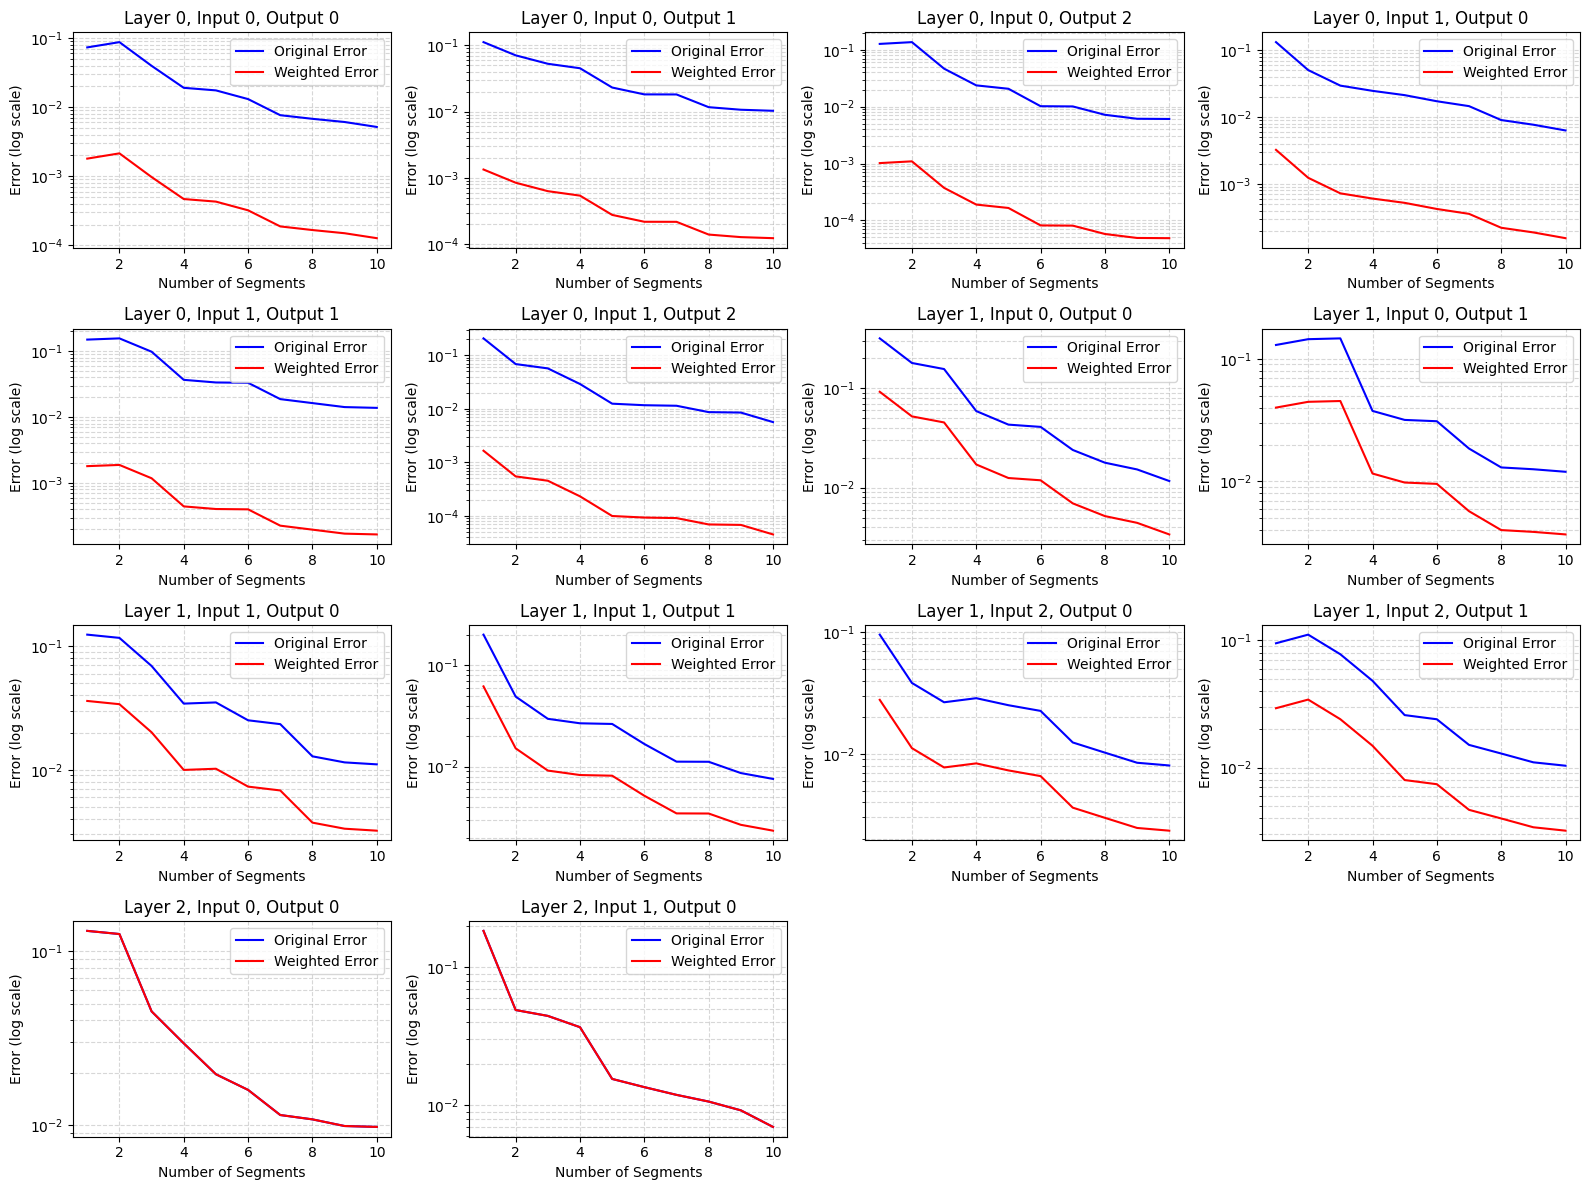

In [ ]:
def compute_dp_tables_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    """
    Analyze and optimize all B-splines in a FastKAN model by computing the error 
    for different numbers of linear segments and calculating Lipschitz constants.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    
    Returns:
    - error_tables: Dictionary mapping (layer_idx, input_idx, output_idx) to an error table.
                   Each error table maps num_segments to error.
    - segments_tables: Dictionary mapping (layer_idx, input_idx, output_idx) to a segments table.
                     Each segments table maps num_segments to segment definitions.
    - lipschitz_constants: Dictionary mapping (layer_idx, input_idx, output_idx) to the 
                          Lipschitz constant of that B-spline.
    """
    error_tables = {}
    segments_tables = {}
    lipschitz_constants = {}
    
    # Iterate through all layers
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Analyzing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        # Iterate through all B-splines in this layer
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Optimize this B-spline
                error_table, segments_table = optimize_bspline(
                    kan_model=kan_model,
                    layer_idx=layer_idx,
                    input_idx=input_idx,
                    output_idx=output_idx,
                    min_x=min_x,
                    max_x=max_x,
                    max_segments=max_segments
                )
                
                # Calculate Lipschitz constant for this B-spline
                lipschitz_constant = calculate_bspline_lipschitz_constant(
                    layer=layer,
                    input_idx=input_idx,
                    output_idx=output_idx
                )
                
                # Store the results
                error_tables[spline_key] = error_table
                segments_tables[spline_key] = segments_table
                lipschitz_constants[spline_key] = lipschitz_constant
                
                print(f"    Lipschitz constant: {lipschitz_constant}")
    
    return error_tables, segments_tables, lipschitz_constants

def calculate_bspline_lipschitz_constant(
    layer: 'FastKANLayer', 
    input_idx: int, 
    output_idx: int, 
    num_pts: int = 1000,
    min_x: float = None,
    max_x: float = None
) -> float:
    """
    Calculate the Lipschitz constant of a B-spline in a FastKAN layer.
    
    The Lipschitz constant is the maximum absolute value of the derivative 
    of the B-spline function. For B-splines, this is the maximum absolute 
    slope across all piecewise segments.
    
    Args:
        layer: FastKANLayer instance containing the B-spline
        input_idx: The input index of the B-spline
        output_idx: The output index of the B-spline
        num_pts: Number of points to sample for numerical derivative calculation
        min_x: Minimum x value to consider (defaults to layer's grid_min if None)
        max_x: Maximum x value to consider (defaults to layer's grid_max if None)
    
    Returns:
        float: The Lipschitz constant (maximum absolute derivative)
    """
    # Set default range if not provided
    if min_x is None:
        min_x = layer.rbf.grid_min
    if max_x is None:
        max_x = layer.rbf.grid_max
    
    # Sample points from the B-spline
    x_tensor, y_tensor = layer.plot_curve(
        input_idx, 
        output_idx, 
        num_pts=num_pts
    )
    
    # Convert to numpy arrays
    x_np = x_tensor.detach().cpu().numpy()
    y_np = y_tensor.detach().cpu().numpy()
    
    # Filter to desired range
    mask = (x_np >= min_x) & (x_np <= max_x)
    x_np = x_np[mask]
    y_np = y_np[mask]
    
    # Calculate numerical derivatives (slopes between adjacent points)
    dx = np.diff(x_np)
    dy = np.diff(y_np)
    
    # Avoid division by zero
    nonzero_dx = dx != 0
    slopes = np.zeros_like(dx)
    slopes[nonzero_dx] = dy[nonzero_dx] / dx[nonzero_dx]
    
    # The Lipschitz constant is the maximum absolute slope
    lipschitz_constant = np.max(np.abs(slopes))
    
    return lipschitz_constant

def get_all_downstream_splines(kan_model, layer_idx, input_idx, output_idx, visited=None):
    """
    Get all downstream splines of a given spline.
    
    Args:
        kan_model (FastKAN): The FastKAN model
        layer_idx (int): Current layer index
        input_idx (int): Input index within the layer
        output_idx (int): Output index within the layer
        visited (set): Set of visited splines to avoid cycles and double-counting
    
    Returns:
        set: Set of tuples (layer_idx, input_idx, output_idx) for all downstream splines
    """
    if visited is None:
        visited = set()
    
    if layer_idx >= len(kan_model.layers) - 1:
        # This is the last layer, no downstream splines
        return set()
    
    # The output of this spline becomes an input in the next layer
    next_input_idx = output_idx
    next_layer_idx = layer_idx + 1
    next_layer = kan_model.layers[next_layer_idx]
    
    downstream_splines = set()
    
    # For each output in the next layer
    for next_output_idx in range(next_layer.output_dim):
        next_spline = (next_layer_idx, next_input_idx, next_output_idx)
        
        if next_spline not in visited:
            visited.add(next_spline)
            downstream_splines.add(next_spline)
            
            # Recursively get all splines downstream of the next spline
            further_downstream = get_all_downstream_splines(
                kan_model, next_layer_idx, next_input_idx, next_output_idx, visited
            )
            downstream_splines.update(further_downstream)
    
    return downstream_splines

def fit_kan_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    """
    Analyze all B-splines in a FastKAN model and weight their errors based on 
    downstream Lipschitz constants.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    
    Returns:
    - weighted_error_tables: Dictionary mapping (layer_idx, input_idx, output_idx) 
                           to a weighted error table. Each weighted error table 
                           maps num_segments to weighted error.
    - segments_tables: Dictionary mapping (layer_idx, input_idx, output_idx) 
                     to a segments table. Each segments table maps num_segments 
                     to segment definitions.
    - lipschitz_constants: Dictionary mapping (layer_idx, input_idx, output_idx) 
                          to the Lipschitz constant of that B-spline.
    """
    # First, compute the DP tables and Lipschitz constants
    error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Initialize the weighted error tables
    weighted_error_tables = {}
    
    # Iterate through all splines in the network
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Weighing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Get all unique downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of Lipschitz constants of all downstream splines
                lipschitz_product = 1.0
                for downstream_spline in downstream_splines:
                    if downstream_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[downstream_spline]
                
                # Weight the error table
                weighted_table = {}
                for num_segments, error in error_tables[spline_key].items():
                    weighted_table[num_segments] = error * lipschitz_product
                
                weighted_error_tables[spline_key] = weighted_table
                
                print(f"    Unique downstream splines: {len(downstream_splines)}")
                print(f"    Lipschitz product: {lipschitz_product}")
    
    return weighted_error_tables, segments_tables, lipschitz_constants

def compare_error_tables(kan_model, min_x=-5.0, max_x=5.0, max_segments=20):
    """
    Compare original error tables with weighted error tables for all splines in a FastKAN model.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    """
    # First, compute the weighted error tables
    weighted_error_tables, segments_tables, lipschitz_constants = fit_kan_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Get the original error tables from compute_dp_tables_lipschitz
    original_error_tables, _, _ = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Create figures to display the comparison
    num_layers = len(kan_model.layers)
    for layer_idx in range(num_layers):
        layer = kan_model.layers[layer_idx]
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"\n====== Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs ======")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Get the original and weighted error tables
                orig_table = original_error_tables[spline_key]
                weighted_table = weighted_error_tables[spline_key]
                
                # Get the Lipschitz constant
                lip_const = lipschitz_constants[spline_key]
                
                # Get the downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of downstream Lipschitz constants
                lipschitz_product = 1.0
                for ds_spline in downstream_splines:
                    if ds_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[ds_spline]
                
                print(f"\nB-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}:")
                print(f"  Lipschitz constant: {lip_const:.4f}")
                print(f"  Downstream Lipschitz product: {lipschitz_product:.4f}")
                print(f"  Number of downstream splines: {len(downstream_splines)}")
                
                # Create a table to display the comparison
                print("\n  Error Table Comparison:")
                print("  -------------------------------------------------------------------------------------")
                print("  | Segments |  Original Error  |  Weighted Error  |  Weight Factor  |  Ratio (W/O)  |")
                print("  -------------------------------------------------------------------------------------")
                
                # Display selected segment counts for clarity
                selected_segments = [1, 2, 3, 5, 10, max_segments]
                for num_segments in selected_segments:
                    if num_segments in orig_table and num_segments in weighted_table:
                        orig_error = orig_table[num_segments]
                        weighted_error = weighted_table[num_segments]
                        
                        # Calculate the ratio
                        ratio = weighted_error / orig_error if orig_error != 0 else float('inf')
                        
                        print(f"  |    {num_segments:2d}    | {orig_error:14.6e} | {weighted_error:14.6e} | {lipschitz_product:14.6e} | {ratio:14.6f} |")
                
                print("  -------------------------------------------------------------------------------------")
    
    # Return all the tables for potential further analysis
    return original_error_tables, weighted_error_tables, lipschitz_constants

def visualize_error_comparison(kan_model, min_x=-5.0, max_x=5.0, max_segments=20):
    """
    Visualize the comparison between original and weighted error tables for all splines
    in the FastKAN model.
    
    Parameters:
    - kan_model: The FastKAN model to analyze
    - min_x, max_x: Range of x values to consider for each B-spline
    - max_segments: Maximum number of segments to evaluate per B-spline
    """
    # Compute the tables
    original_tables, weighted_tables, lipschitz_constants = compare_error_tables(
        kan_model, min_x, max_x, max_segments
    )
    
    # Count the total number of splines
    total_splines = sum(
        layer.input_dim * layer.output_dim 
        for layer in kan_model.layers
    )
    
    # Set up the figure with subplots (adjust the layout based on the number of splines)
    rows = int(np.ceil(np.sqrt(total_splines)))
    cols = int(np.ceil(total_splines / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)
    
    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()
    
    # Counter for subplot index
    subplot_idx = 0
    
    # For each layer and spline
    for layer_idx, layer in enumerate(kan_model.layers):
        for input_idx in range(layer.input_dim):
            for output_idx in range(layer.output_dim):
                if subplot_idx >= len(axes_flat):
                    break  # In case we have more splines than subplots
                
                ax = axes_flat[subplot_idx]
                spline_key = (layer_idx, input_idx, output_idx)
                
                # Get original and weighted errors
                orig_errors = [original_tables[spline_key].get(s, 0) for s in range(1, max_segments+1)]
                weighted_errors = [weighted_tables[spline_key].get(s, 0) for s in range(1, max_segments+1)]
                
                # Plot the data
                segments = list(range(1, max_segments+1))
                ax.plot(segments, orig_errors, 'b-', label='Original Error')
                ax.plot(segments, weighted_errors, 'r-', label='Weighted Error')
                
                # Add logarithmic scale for better visualization
                ax.set_yscale('log')
                
                # Add title and labels
                ax.set_title(f'Layer {layer_idx}, Input {input_idx}, Output {output_idx}')
                ax.set_xlabel('Number of Segments')
                ax.set_ylabel('Error (log scale)')
                ax.legend()
                ax.grid(True, which="both", ls="--", alpha=0.5)
                
                subplot_idx += 1
    
    # Remove any unused subplots
    for i in range(subplot_idx, len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    plt.tight_layout()
    
    # Return the figure for further customization or saving
    return fig

# Example usage with a small FastKAN model
def create_example_kan_model():
    """Create a small FastKAN model for testing."""
    # Define the layer sizes: input, hidden layers, output
    layers_hidden = [2, 3, 2, 1]  # 2 inputs -> 3 hidden -> 2 hidden -> 1 output
    
    # Create the model
    model = FastKAN(
        layers_hidden=layers_hidden,
        grid_min=-2.0,
        grid_max=2.0,
        num_grids=8,
        use_base_update=True,
    )
    
    return model

def demo_error_comparison():
    """Demonstrate the error comparison on a small example model."""
    print("Creating example FastKAN model...")
    model = create_example_kan_model()
    
    print("\nComparing original and weighted error tables...")
    # Use smaller max_segments for this demo
    fig = visualize_error_comparison(model, min_x=-2.0, max_x=2.0, max_segments=10)
    
    print("\nVisualization complete. Close the plot window to continue.")
    plt.show()
    
    return model

model = demo_error_comparison()

In [ ]:
def weight_dp_tables_lipschitz(kan_model, min_x=-5.0, max_x=5.0, max_segments=15):
    error_tables, segments_tables, lipschitz_constants = compute_dp_tables_lipschitz(
        kan_model, min_x, max_x, max_segments
    )
    
    # Initialize the weighted error tables
    weighted_error_tables = {}
    
    # Iterate through all splines in the network
    for layer_idx, layer in enumerate(kan_model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        
        print(f"Weighing Layer {layer_idx}: {input_dim} inputs -> {output_dim} outputs")
        
        for input_idx in range(input_dim):
            for output_idx in range(output_dim):
                spline_key = (layer_idx, input_idx, output_idx)
                print(f"  Processing B-spline at Layer {layer_idx}, Input {input_idx}, Output {output_idx}...")
                
                # Get all unique downstream splines
                downstream_splines = get_all_downstream_splines(
                    kan_model, layer_idx, input_idx, output_idx
                )
                
                # Compute the product of Lipschitz constants of all downstream splines
                lipschitz_product = 1.0
                for downstream_spline in downstream_splines:
                    if downstream_spline in lipschitz_constants:
                        lipschitz_product *= lipschitz_constants[downstream_spline]
                
                # Weight the error table
                weighted_table = {}
                for num_segments, error in error_tables[spline_key].items():
                    weighted_table[num_segments] = error * lipschitz_product
                
                weighted_error_tables[spline_key] = weighted_table
                
                print(f"    Unique downstream splines: {len(downstream_splines)}")
                print(f"    Lipschitz product: {lipschitz_product}")
    
    return weighted_error_tables, segments_tables, lipschitz_constants

def fit_kan_optimally_lipschitz(kan_model, weighted_error_tables, segments_tables, max_error, 
                             min_x=-5.0, max_x=5.0, max_segments=50):
    all_splines = list(weighted_error_tables.keys())
    num_splines = len(all_splines)
    
    print(f"Optimizing segment allocation for {num_splines} B-splines...")
    
    max_total_segments = min(num_splines * max_segments, 1000)
    
    # Initialize DP table: dp[i][j] represents the minimum error achievable when
    # allocating j total segments to the first i splines
    dp = np.full((num_splines + 1, max_total_segments + 1), float('inf'))
    dp[0, 0] = 0  # Base case: 0 error when allocating 0 segments to 0 splines
    backtrack = np.zeros((num_splines + 1, max_total_segments + 1), dtype=int)
    all_spline_errors = {}
    # look at 1 spline at a time
     
    
    # Find the minimum total segments that achieve error <= max_error
    optimal_total_segments = None
    achieved_error = float('inf')
    for j in range(max_total_segments + 1):
        if dp[num_splines, j] <= max_error:
            optimal_total_segments = j
            achieved_error = dp[num_splines, j]
            break
    
    # Reconstruct the optimal allocation
    optimal_allocation = {}
    actual_segments = {}
    remaining_segments = optimal_total_segments
    for i in range(num_splines, 0, -1):
        spline_key = all_splines[i-1]
        segs_for_spline = backtrack[i, remaining_segments]
        optimal_allocation[spline_key] = segs_for_spline
        actual_segments[spline_key] = segments_tables[spline_key].get(segs_for_spline, [])
        remaining_segments -= segs_for_spline
    
    total_segments = sum(optimal_allocation.values())
    print(f"  Achieved error: {achieved_error}")
    return optimal_allocation, actual_segments, total_segments, achieved_error, dp

def construct_simplified_kan(kan_model, optimal_allocation, actual_segments):
    """
    Construct a simplified version of the KAN using the optimal segment allocation.
    
    Parameters:
    - kan_model: The original FastKAN model
    - optimal_allocation: Dictionary mapping (layer_idx, input_idx, output_idx) to the optimal number of segments
    - actual_segments: Dictionary mapping (layer_idx, input_idx, output_idx) to the actual segment definitions
    
    Returns:
    - simplified_kan: A new model representing the simplified KAN
    """
    # This function would create a new model structure using the optimized
    # piecewise linear segments rather than the original B-splines
    
    # Implementation would depend on how you want to represent the simplified model
    # For now, we'll return a structure describing the simplified model
    
    simplified_model = {
        'architecture': [layer.output_dim for layer in kan_model.layers],
        'total_segments': sum(optimal_allocation.values()),
        'segment_allocation': optimal_allocation,
        'segment_definitions': actual_segments
    }
    
    return simplified_model

def print_dp_table(dp_table, num_splines, max_total_segments, step=5):
    """
    Print the dynamic programming table in a readable format.
    
    Parameters:
    - dp_table: The DP table from fit_kan_optimally_lipschitz
    - num_splines: Number of splines (rows in the DP table)
    - max_total_segments: Maximum total segments (columns in the DP table)
    - step: Step size for printing columns (to avoid overwhelming output)
    """
    import numpy as np
    
    print("\nDynamic Programming Table (Error values):")
    print("-" * 80)
    
    # Header row with column indices
    header = "Spline \\ Segments"
    for j in range(0, min(max_total_segments + 1, 100), step):
        header += f" | {j:5d}"
    print(header)
    print("-" * len(header))
    
    # Print rows with error values
    for i in range(num_splines + 1):
        row = f"{i:3d}"
        for j in range(0, min(max_total_segments + 1, 100), step):
            if np.isinf(dp_table[i, j]):
                row += " | inf  "
            else:
                row += f" | {dp_table[i, j]:.3f}"
        print(row)
    
    print("-" * 80)
    print("Note: 'inf' indicates that the error is infinite (impossible allocation)")
    print("Only the first 100 columns are shown (if applicable)")

def visualize_all_splines(kan_model, optimal_allocation, actual_segments):
    """
    Visualize all splines in the KAN model with their optimal allocations.
    Creates a grid of plots showing all original and simplified splines.
    
    Parameters:
    - kan_model: The original FastKAN model
    - optimal_allocation: Dictionary mapping (layer_idx, input_idx, output_idx) to the optimal number of segments
    - actual_segments: Dictionary mapping (layer_idx, input_idx, output_idx) to the actual segment definitions
    
    Returns:
    - A list of figure objects, one per layer
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    
    # Group splines by layer for better organization
    splines_by_layer = {}
    for spline_key in optimal_allocation.keys():
        layer_idx, input_idx, output_idx = spline_key
        if layer_idx not in splines_by_layer:
            splines_by_layer[layer_idx] = []
        splines_by_layer[layer_idx].append((input_idx, output_idx))
    
    figures = []
    
    # Create a separate figure for each layer
    for layer_idx, splines in splines_by_layer.items():
        layer = kan_model.layers[layer_idx]
        num_splines = len(splines)
        
        # Determine grid dimensions (try to make it roughly square)
        grid_size = math.ceil(math.sqrt(num_splines))
        rows = math.ceil(num_splines / grid_size)
        cols = min(grid_size, num_splines)
        
        # Create figure and subplots
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
        fig.suptitle(f"Layer {layer_idx}: All Splines with Optimal Segment Allocation", fontsize=16)
        
        # Flatten axes if it's a grid
        if num_splines > 1:
            axes_flat = axes.flatten()
        else:
            axes_flat = [axes]
        
        # Plot each spline in this layer
        for i, (input_idx, output_idx) in enumerate(splines):
            if i >= len(axes_flat):
                break
                
            ax = axes_flat[i]
            spline_key = (layer_idx, input_idx, output_idx)
            
            # Get the original spline
            x_tensor, y_tensor = layer.plot_curve(input_idx, output_idx, num_pts=1000)
            x_original = x_tensor.detach().cpu().numpy()
            y_original = y_tensor.detach().cpu().numpy()
            
            # Get the simplified spline
            segments = actual_segments[spline_key]
            x_simplified = []
            y_simplified = []
            
            for x1, x2, slope, intercept in segments:
                segment_x = np.linspace(x1, x2, 50)
                segment_y = slope * segment_x + intercept
                x_simplified.extend(segment_x)
                y_simplified.extend(segment_y)
            
            # Plot
            ax.plot(x_original, y_original, 'b-', label='Original')
            ax.plot(x_simplified, y_simplified, 'r--', label=f'{optimal_allocation[spline_key]} segments')
            
            # Mark segment boundaries
            for x1, x2, _, _ in segments:
                ax.axvline(x=x1, color='g', linestyle=':', alpha=0.5)
            
            ax.set_title(f'Input {input_idx} → Output {output_idx}')
            ax.legend(loc='best', fontsize='small')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots if any
        for j in range(num_splines, len(axes_flat)):
            axes_flat[j].set_visible(False)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for the suptitle
        figures.append(fig)
    
    return figures

def visualize_optimization_results(kan_model, optimal_allocation, actual_segments, weighted_error_tables):
    """
    Visualize the results of the optimization, showing original B-splines and their simplified versions.
    
    Parameters:
    - kan_model: The original FastKAN model
    - optimal_allocation: Dictionary mapping (layer_idx, input_idx, output_idx) to the optimal number of segments
    - actual_segments: Dictionary mapping (layer_idx, input_idx, output_idx) to the actual segment definitions
    - weighted_error_tables: Dictionary mapping (layer_idx, input_idx, output_idx) to weighted error tables
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Sample a few optimized splines to visualize
    sample_size = min(5, len(optimal_allocation))
    sample_splines = list(optimal_allocation.keys())[:sample_size]
    
    fig, axes = plt.subplots(sample_size, 1, figsize=(10, 4 * sample_size))
    if sample_size == 1:
        axes = [axes]
    
    for i, spline_key in enumerate(sample_splines):
        layer_idx, input_idx, output_idx = spline_key
        layer = kan_model.layers[layer_idx]
        
        # Get the original spline
        x_tensor, y_tensor = layer.plot_curve(input_idx, output_idx, num_pts=1000)
        x_original = x_tensor.detach().cpu().numpy()
        y_original = y_tensor.detach().cpu().numpy()
        
        # Get the simplified spline
        segments = actual_segments[spline_key]
        x_simplified = []
        y_simplified = []
        
        for x1, x2, slope, intercept in segments:
            segment_x = np.linspace(x1, x2, 50)
            segment_y = slope * segment_x + intercept
            x_simplified.extend(segment_x)
            y_simplified.extend(segment_y)
        
        # Plot
        ax = axes[i]
        ax.plot(x_original, y_original, 'b-', label=f'Original B-spline')
        ax.plot(x_simplified, y_simplified, 'r--', label=f'Simplified ({optimal_allocation[spline_key]} segments)')
        
        # Mark segment boundaries
        for x1, x2, _, _ in segments:
            ax.axvline(x=x1, color='g', linestyle=':', alpha=0.5)
        
        ax.set_title(f'Layer {layer_idx}, Input {input_idx}, Output {output_idx}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

 # First, compute the weighted error tables
kan_model = FastKAN([2, 6, 2])  # Replace with your actual FastKAN model
weighted_error_tables, segments_tables, lipschitz_constants = weight_dp_tables_lipschitz(
    kan_model, min_x=-5.0, max_x=5.0, max_segments=8
)

# Then, find the optimal allocation (now returns the DP table too)
optimal_allocation, actual_segments, total_segments, achieved_error, dp_table = fit_kan_optimally_lipschitz(
    kan_model, 
    weighted_error_tables, 
    segments_tables, 
    max_error=0.1
)

# Print the DP table for analysis
print_dp_table(dp_table, len(optimal_allocation), total_segments)

# Visualize all splines with their optimal allocations
figures = visualize_all_splines(kan_model, optimal_allocation, actual_segments)

# If you want to save the figures to disk
for i, fig in enumerate(figures):
    fig.savefig(f"layer_{i}_splines.png")

Analyzing Layer 0: 2 inputs -> 6 outputs
  Processing B-spline at Layer 0, Input 0, Output 0...
    Lipschitz constant: 0.46556761860847473
  Processing B-spline at Layer 0, Input 0, Output 1...
    Lipschitz constant: 0.4985932409763336
  Processing B-spline at Layer 0, Input 0, Output 2...
    Lipschitz constant: 0.37770339846611023
  Processing B-spline at Layer 0, Input 0, Output 3...
    Lipschitz constant: 0.4171760380268097
  Processing B-spline at Layer 0, Input 0, Output 4...
    Lipschitz constant: 0.4471142590045929
  Processing B-spline at Layer 0, Input 0, Output 5...
    Lipschitz constant: 0.3502434492111206
  Processing B-spline at Layer 0, Input 1, Output 0...
    Lipschitz constant: 0.39090046286582947
  Processing B-spline at Layer 0, Input 1, Output 1...
    Lipschitz constant: 0.4337330162525177
  Processing B-spline at Layer 0, Input 1, Output 2...
    Lipschitz constant: 0.33292698860168457
  Processing B-spline at Layer 0, Input 1, Output 3...
    Lipschitz cons

TypeError: unhashable type: 'numpy.ndarray'

def fit_kan_lipschitz():
    for plus_node in KAN:
        allocate_single_plus_node(plus_node, all_previous_dp_tables)

Make allocate_single_plus_node take in a new variable called all_previous_dp_tables. all_previous_dp_tables contains the error table we have computed for each bspline up until this point. It's an array of error tables where the bspline



def fit_kan_lipschitz():
   1. Get allocate_single_plus_node() to actually take in a plus node and return DP table
   2. Once we have this we’ll have a dynamic programming table for each set of bsplines. Which tells us if you allocate a certain number of segments then this addition node will return this error
   2. Make allocate_single_plus_node take in a new variable all_previous_dp_tables. Ex. The function will make a new table which will have number of segments on x axis and spline number on y-axis. It will get the 2 bsplines associated with the plus node. Lets look at trying to fill in cell with allocation of 5 segments at bspline 1. We will try the 

   3. Then these will feed into another 2 b-splines. which feed into Layer 2: plus node 1 and plus node 2
      For plus node 1:
        Create a dynamic programming table which has the 3 bsplines that feed into it on y axis and number of segments on x axis.

Questions:
The way I have this setup, each layer will have to take in a bigger and bigger max_segments budget

# Verification With Sampling

![image.png](python_sampling.png)

Dynamic Programming Table for first B-spline (input=0, output=0):
----------------------------------------------------------------------
Num Segments | Max Error | Segments
----------------------------------------------------------------------
           1 | 0.2322    | 1
           2 | 0.1931    | 2
           3 | 0.0962    | 3
           4 | 0.0808    | 4
           5 | 0.0561    | 5
           6 | 0.0331    | 6
           7 | 0.0246    | 7
           8 | 0.0202    | 8
           9 | 0.0166    | 9
          10 | 0.0127    | 10
          11 | 0.0110    | 11
          12 | 0.0107    | 12
          13 | 0.0086    | 13
          14 | 0.0085    | 14
          15 | 0.0083    | 15
          16 | 0.0070    | 16
          17 | 0.0070    | 17
          18 | 0.0069    | 18
          19 | 0.0065    | 19
          20 | 0.0055    | 20

Detailed segment information for selected segmentations:

For 1 segments (max error = 0.2322):
  Segment | Start x | End x   | Slope     | Intercept
  -------------

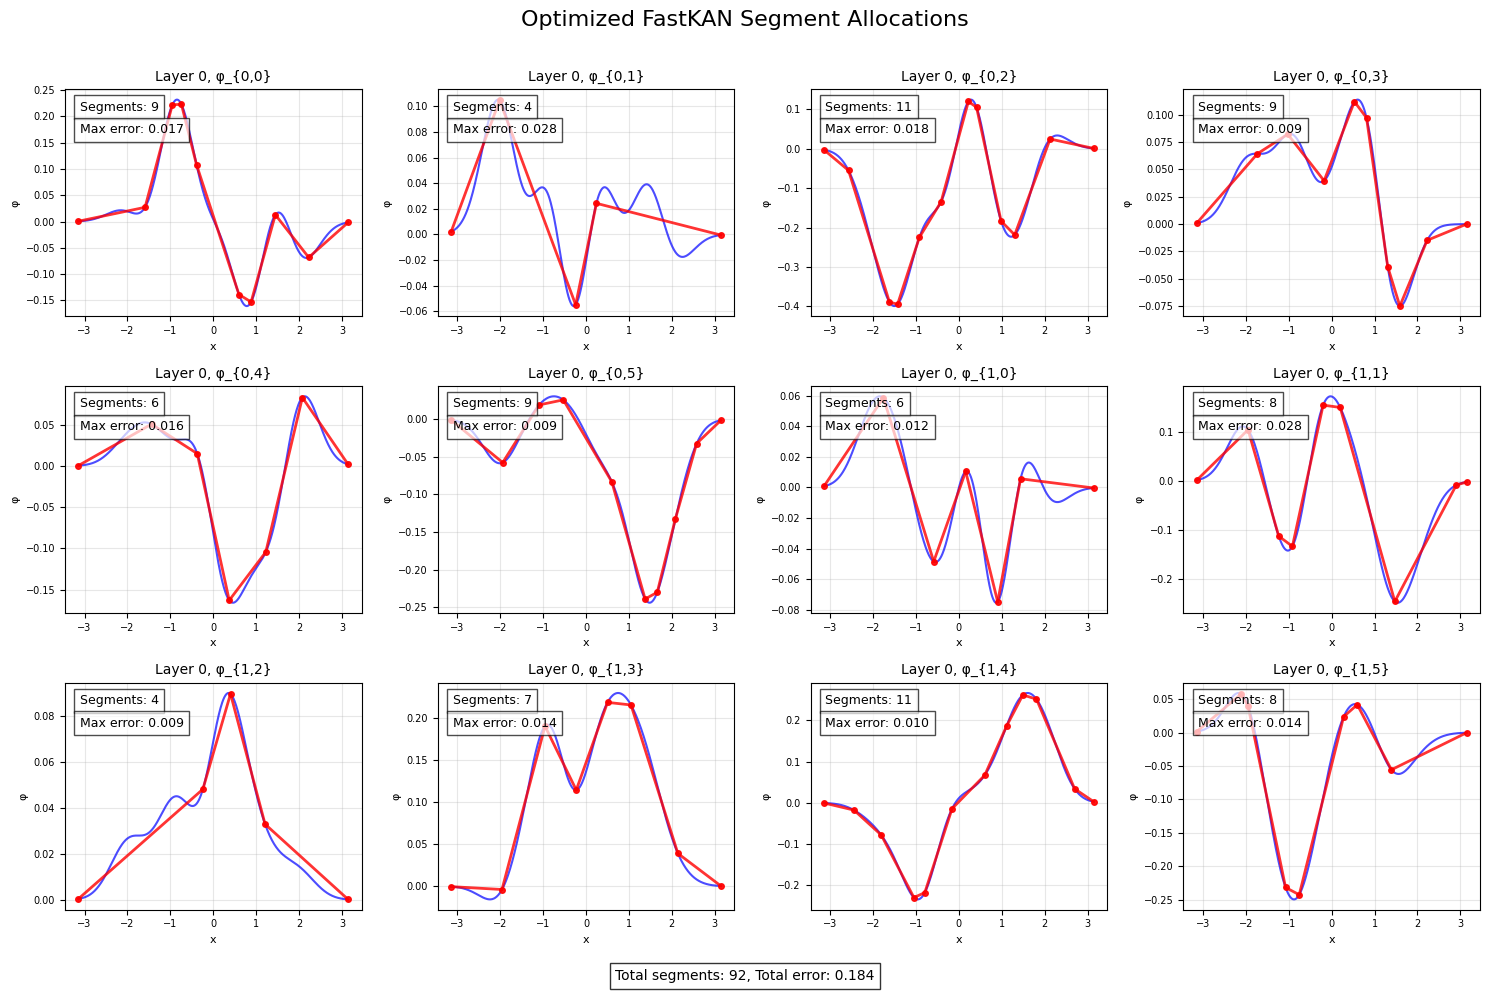

In [ ]:
def create_bspline_dp_table_sampling(kan_model, min_x=-5.0, max_x=5.0, max_segments=15, show_first_dp=True):
    layer = kan_model.layers[0]
    input_dim = layer.input_dim
    output_dim = layer.output_dim
    n_samples = 1000
    results = {}
    
    # Flag to track if we've already displayed the first DP table
    first_dp_displayed = False
    
    # For each input-output pair in the layer
    for input_index in range(input_dim):
        for output_index in range(output_dim):
            # Key for this specific b-spline
            key = f"layer0_in{input_index}_out{output_index}"
            results[key] = {"segments": [], "errors": []}
            
            # Get the original b-spline output
            x_tensor, y_tensor = layer.plot_curve(
                input_index, output_index, 
                num_pts=n_samples
            )
            
            # Convert to numpy for faster processing
            x_np = x_tensor.detach().cpu().numpy()
            y_np = y_tensor.detach().cpu().numpy()
            
            # Filter to desired range
            mask = (x_np >= min_x) & (x_np <= max_x)
            x_np = x_np[mask]
            y_np = y_np[mask]
            
            # Create a DP table for this b-spline
            dp_table = []
            
            # Try different segment counts
            for num_segments in range(1, max_segments + 1):
                # Find the optimal segments for this count
                segments, error = find_bspline_segments_given_max_segments(
                    layer, input_index, output_index, num_segments, min_x, max_x
                )
                
                # If no valid segments were found, use infinity as the error
                if not segments:
                    dp_table.append(float('inf'))
                    results[key]["segments"].append([])
                    results[key]["errors"].append(float('inf'))
                    continue
                
                # Apply the piecewise linear approximation to the sample points
                y_approx = np.zeros_like(y_np)
                
                # Vectorized approach to find which segment each x value belongs to
                for x1, x2, slope, intercept in segments:
                    # Create a mask for points in this segment
                    segment_mask = (x_np >= x1) & (x_np <= x2)
                    # Apply the linear function to these points
                    y_approx[segment_mask] = slope * x_np[segment_mask] + intercept
                
                # Calculate maximum approximation error
                max_error = np.max(np.abs(y_np - y_approx))
                
                # Store results
                dp_table.append(max_error)
                results[key]["segments"].append(segments)
                results[key]["errors"].append(max_error)
            
            # Add the DP table to the results
            results[key]["dp_table"] = dp_table
            
            # Display the DP table for the first processed B-spline
            if show_first_dp and not first_dp_displayed:
                print(f"Dynamic Programming Table for first B-spline (input={input_index}, output={output_index}):")
                print("-" * 70)
                print("Num Segments | Max Error | Segments")
                print("-" * 70)
                
                for seg_idx in range(len(dp_table)):
                    num_segments = seg_idx + 1
                    error = dp_table[seg_idx]
                    segments_count = len(results[key]["segments"][seg_idx]) if results[key]["segments"][seg_idx] else 0
                    
                    # Format error to handle infinity
                    error_str = f"{error:.4f}" if error != float('inf') else "inf"
                    
                    # Print summary for this number of segments
                    print(f"{num_segments:12} | {error_str:9} | {segments_count}")
                
                # Print the actual segment details for some selected numbers of segments
                print("\nDetailed segment information for selected segmentations:")
                
                # Choose a few representative segment counts to display details for
                segment_counts_to_show = [1, 3, max_segments] if max_segments > 3 else range(1, max_segments+1)
                
                for seg_count in segment_counts_to_show:
                    idx = seg_count - 1
                    if idx < len(results[key]["segments"]):
                        segments = results[key]["segments"][idx]
                        error = results[key]["errors"][idx]
                        error_str = f"{error:.4f}" if error != float('inf') else "inf"
                        
                        print(f"\nFor {seg_count} segments (max error = {error_str}):")
                        if not segments:
                            print("  No valid segmentation found")
                        else:
                            print("  Segment | Start x | End x   | Slope     | Intercept")
                            print("  " + "-" * 58)
                            for i, (x1, x2, slope, intercept) in enumerate(segments):
                                print(f"  {i+1:7} | {x1:7.3f} | {x2:7.3f} | {slope:9.4f} | {intercept:9.4f}")
                
                # Mark that we've displayed the first DP table
                first_dp_displayed = True
    
    return results

def fit_layer_1_sampling(kan_model, min_x=-5.0, max_x=5.0, max_error_layer_1=0.5):
    """
    Optimally allocate segments to B-splines in layer 1 to minimize total segments while keeping error below max_error_layer_1.
    
    Args:
        kan_model: The FastKAN model
        min_x: Minimum x value for the domain
        max_x: Maximum x value for the domain
        max_error_layer_1: Maximum error allowed for layer 1
        
    Returns:
        List of tuples with (layer_idx, input_index, output_index, segments, max_error)
    """
    # Step 1: Create the DP tables for layer 1's B-splines
    dp_results = create_bspline_dp_table_sampling(kan_model, min_x, max_x, max_segments=20)  # Use up to 20 segments per spline
    
    # Step 2: Extract the layer 1 B-splines and their errors
    layer = kan_model.layers[0]
    input_dim = layer.input_dim
    output_dim = layer.output_dim
    
    # Store each B-spline's error information
    splines = []
    for input_index in range(input_dim):
        for output_index in range(output_dim):
            key = f"layer0_in{input_index}_out{output_index}"
            splines.append({
                'key': key,
                'input_index': input_index,
                'output_index': output_index,
                'errors': dp_results[key]['errors'],
                'segments': dp_results[key]['segments']
            })
    
    # Step 3: Use DP to find the optimal segment allocation
    
    # Initialize the DP table
    # dp[i][e] = minimum total segments needed to approximate the first i splines
    # with a total error of at most e
    n_splines = len(splines)
    
    # Discretize the error space for DP
    error_precision = 100  # Number of discrete error levels
    max_error_discrete = int(max_error_layer_1 * error_precision)
    
    # Initialize DP table with infinity
    dp = {}
    backtrack = {}
    
    # Base case: 0 splines, 0 error, 0 segments
    dp[(0, 0)] = 0
    
    # Print header for the DP table
    print("\n" + "="*80)
    print("DYNAMIC PROGRAMMING TABLE FOR SEGMENT ALLOCATION")
    print("="*80)
    print("Notation: dp[spline_idx, error] = total_segments")
    print("-"*80)
    
    # Initialize a tracking dictionary to collect entries for a readable table
    dp_entries = {}
    
    # Fill the DP table
    for i in range(n_splines):
        spline = splines[i]
        spline_key = f"in{spline['input_index']}_out{spline['output_index']}"
        
        print(f"\nProcessing spline {i+1}/{n_splines}: {spline_key}")
        
        # Track entries for this spline
        spline_entries = []
        
        for prev_err in range(max_error_discrete + 1):
            if (i, prev_err) not in dp:
                continue
                
            for segments_idx in range(len(spline['errors'])):
                error = spline['errors'][segments_idx]
                num_segments = len(spline['segments'][segments_idx])
                
                if error == float('inf'):
                    continue  # Skip invalid segment counts
                
                # Calculate new discretized error
                new_err_discrete = prev_err + int(error * error_precision)
                
                # Skip if we exceed the maximum error
                if new_err_discrete > max_error_discrete:
                    continue
                
                # Calculate total segments with this allocation
                total_segments = dp[(i, prev_err)] + num_segments
                
                # Update DP if this is better than existing solution
                if (i+1, new_err_discrete) not in dp or total_segments < dp[(i+1, new_err_discrete)]:
                    dp[(i+1, new_err_discrete)] = total_segments
                    backtrack[(i+1, new_err_discrete)] = (i, prev_err, segments_idx + 1)  # +1 because segments_idx is 0-based
                    
                    # Add entry to our tracking dictionary for the formatted table
                    spline_entries.append({
                        'prev_error': prev_err / error_precision,
                        'new_error': new_err_discrete / error_precision,
                        'segments_added': num_segments,
                        'total_segments': total_segments,
                        'segment_error': error
                    })
        
        # Sort and display the entries for this spline
        if spline_entries:
            spline_entries.sort(key=lambda x: x['total_segments'])
            print(f"  Selected DP entries for spline {spline_key}:")
            print("  " + "-"*70)
            print("  {:^12} | {:^12} | {:^12} | {:^12} | {:^12}".format(
                "Prev Error", "Segments", "Seg Error", "New Error", "Total Segs"))
            print("  " + "-"*70)
            
            # Show at most 10 entries for readability
            for entry in spline_entries[:10]:
                print("  {:12.4f} | {:12d} | {:12.4f} | {:12.4f} | {:12d}".format(
                    entry['prev_error'], 
                    entry['segments_added'],
                    entry['segment_error'],
                    entry['new_error'],
                    entry['total_segments']))
            
            # If there are more entries, show this
            if len(spline_entries) > 10:
                print(f"  ... and {len(spline_entries) - 10} more entries")
        else:
            print("  No valid DP entries for this spline")
    
    # Step 4: Find the optimal solution that minimizes total segments
    min_segments = float('inf')
    best_state = None
    
    print("\n" + "="*50)
    print("FINAL SOLUTION CANDIDATES")
    print("="*50)
    print("{:^12} | {:^12} | {:^12}".format("Error", "Total Segments", "State"))
    print("-"*50)
    
    # Sort and display the final states by total segments
    final_states = []
    for err in range(max_error_discrete + 1):
        if (n_splines, err) in dp:
            total_segs = dp[(n_splines, err)]
            final_states.append((err / error_precision, total_segs, (n_splines, err)))
            if total_segs < min_segments:
                min_segments = total_segs
                best_state = (n_splines, err)
    
    # Sort and print the final states
    final_states.sort(key=lambda x: x[1])  # Sort by total segments
    for error, segments, state in final_states[:15]:  # Show top 15 solutions
        is_best = "✓" if state == best_state else " "
        print("{:12.4f} | {:12d} | {:12s} {}".format(
            error, segments, f"({state[0]}, {state[1]})", is_best))
    
    if len(final_states) > 15:
        print(f"... and {len(final_states) - 15} more solutions")
    
    # Step 5: Backtrack to find the segment allocation
    if best_state is None:
        print("\nNo valid solution found!")
        return []  # No valid solution found
    
    print("\n" + "="*70)
    print(f"OPTIMAL SOLUTION: {min_segments} segments with error {best_state[1]/error_precision:.4f}")
    print("="*70)
    
    # Print the backtracking process
    print("\nBacktracking to find optimal allocation:")
    print("{:<5} | {:<12} | {:<12} | {:<12} | {:<12}".format(
        "Step", "Spline", "Prev State", "Segments", "Error"))
    print("-"*70)
    
    allocation = []
    curr_state = best_state
    step_count = 1
    
    while curr_state in backtrack:
        prev_i, prev_err, segments_count = backtrack[curr_state]
        spline_idx = prev_i
        spline = splines[spline_idx]
        
        # Get the actual segments and error
        seg_idx = segments_count - 1  # Convert back to 0-based index
        actual_error = spline['errors'][seg_idx]
        num_segments = len(spline['segments'][seg_idx])
        
        spline_key = f"in{spline['input_index']}_out{spline['output_index']}"
        
        print("{:<5} | {:<12} | {:<12} | {:<12} | {:<12.4f}".format(
            step_count, 
            spline_key, 
            f"({prev_i}, {prev_err})",
            num_segments,
            actual_error
        ))
        
        allocation.append((
            spline['input_index'],
            spline['output_index'],
            seg_idx
        ))
        
        curr_state = (prev_i, prev_err)
        step_count += 1
    
    # Reverse to get the correct order
    allocation.reverse()
    
    # Step 6: Convert allocation to the expected output format
    all_segments = []
    total_error = 0
    
    for input_index, output_index, segments_idx in allocation:
        key = f"layer0_in{input_index}_out{output_index}"
        segments = dp_results[key]['segments'][segments_idx]
        error = dp_results[key]['errors'][segments_idx]
        
        all_segments.append((
            0,  # layer_idx = 0 for layer 1
            input_index,
            output_index,
            segments,
            error
        ))
        
        total_error += error
    
    print(f"\nOptimized layer 1 with {min_segments} total segments and total error {total_error:.4f}")
    return all_segments

def plot_optimized_kan(
    kan_model,
    optimized_segments,
    figsize=(15, 10),
    min_x=-5.0,
    max_x=5.0,
    num_pts=500,
    show_knot_points=True,
    show_error=True,
    color_original='blue',
    color_segments='red',
    color_knots='red',
    alpha_original=0.7,
    alpha_segments=0.8,
    save_path=None
):
    """
    optimized_segments: List of tuples (layer_idx, input_index, output_index, segments, max_error)
    """
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Count total B-splines to plot
    total_curves = len(optimized_segments)
    if total_curves == 0:
        return plt.figure(figsize=(6, 4))  # Return empty figure if no segments
    
    # Calculate grid layout
    cols = math.ceil(math.sqrt(total_curves))
    rows = math.ceil(total_curves / cols)
    
    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('Optimized FastKAN Segment Allocations', fontsize=16)
    axes = axes.flatten()
    
    # Total segment count for statistics
    total_segment_count = 0
    total_error = 0.0
    
    # Plot each B-spline
    for idx, (layer_idx, input_index, output_index, segments, max_error) in enumerate(optimized_segments):
        if idx >= len(axes):
            break  # Safety check
            
        ax = axes[idx]
        layer = kan_model.layers[layer_idx]
        
        # Get the original B-spline curve
        x_tensor, y_tensor = layer.plot_curve(
            input_index, output_index, 
            num_pts=num_pts
        )
        
        # Convert to numpy arrays
        x_orig = x_tensor.detach().cpu().numpy()
        y_orig = y_tensor.detach().cpu().numpy()
        
        # Filter to desired range
        mask = (x_orig >= min_x) & (x_orig <= max_x)
        x_orig = x_orig[mask]
        y_orig = y_orig[mask]
        
        # Plot original curve
        ax.plot(x_orig, y_orig, '-', color=color_original, linewidth=1.5, 
                alpha=alpha_original, label='Original B-spline')
        
        # Count segments and gather knot points for this B-spline
        segment_count = len(segments)
        total_segment_count += segment_count
        knot_points_x = []
        knot_points_y = []
        
        # Plot each linear segment
        for x1, x2, slope, intercept in segments:
            # Generate points along this segment
            x_seg = np.linspace(x1, x2, 50)
            y_seg = slope * x_seg + intercept
            
            # Plot the segment
            ax.plot(x_seg, y_seg, '-', color=color_segments, linewidth=2, alpha=alpha_segments)
            
            # Add knot points
            knot_points_x.extend([x1, x2])
            knot_points_y.extend([slope * x1 + intercept, slope * x2 + intercept])
        
        # Plot knot points if requested
        if show_knot_points and knot_points_x:
            # Remove duplicates (where segments connect)
            unique_points = {}
            for x, y in zip(knot_points_x, knot_points_y):
                # Round to avoid floating-point issues
                key = round(x, 6)
                unique_points[key] = y
                
            unique_x = list(unique_points.keys())
            unique_y = list(unique_points.values())
            
            ax.plot(unique_x, unique_y, 'o', color=color_knots, markersize=4, alpha=0.9)
        
        # Display error and segment count
        if show_error:
            ax.text(0.05, 0.95, f'Segments: {segment_count}', transform=ax.transAxes, 
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.7), 
                    verticalalignment='top')
            ax.text(0.05, 0.85, f'Max error: {max_error:.3f}', transform=ax.transAxes, 
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.7), 
                    verticalalignment='top')
        
        # Add to average error calculation
        total_error += max_error
        
        # Set title and labels
        ax.set_title(f'Layer {layer_idx}, φ_{{{input_index},{output_index}}}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        ax.set_ylabel(f'φ', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3)
    
    # Turn off unused subplots
    for i in range(total_curves, len(axes)):
        axes[i].axis('off')
    
    # Add summary statistics to the figure
    fig.text(0.5, 0.01, f'Total segments: {total_segment_count}, Total error: {total_error:.3f}', 
             ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Example usage:
#1. Create a KAN model
kan_model = FastKAN([2, 6, 2])

#2. Find optimized segment allocations
optimized_segments = fit_layer_1_sampling(kan_model, min_x=-5.0, max_x=5.0, max_error_layer_1=0.1)

#3. Plot the optimized allocation
fig = plot_optimized_kan(kan_model, optimized_segments)
plt.show()

def fit_kan_sampling():
   all_segments = fit_layer_1_sampling() #list of tuples with (layer_idx, input_index, output_index, segments, max_error)
   1. for each plus node in KAN just add up all the errors entering it
   2. get the 500 points with highest error from spline 1 and add it to 500 points with highest error from spline 2
   3. pass these points into the next BSpline 
   4. get the DP table for this BSpline
   5. Do this for all BSplines in the layer
   6. Fit all of those correctly according to error budget
   7. Move to the next layer and do the same

Why do we need to store the piecewise linearization for each number of pieces then? Unless we're doing a full on DP approach like lipschitz
Shouldn't we be keeping track of error from previous layers?